In [1]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('./src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from CNN import CNN
import similarities 
import DShap
from LOO import LOO
from sklearn.utils.class_weight import compute_class_weight
from utils import load_data, get_filtered_scores

from Estimator import Estimator
from Estimator2 import Estimator2
from DVRL2 import DVRL2

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data 

In [2]:
x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise, kwargs = load_data(dataset     = 'adult', 
                                                                                                train_num   = 1000, 
                                                                                                valid_num   = 400, 
                                                                                                exog_noise  = 0., 
                                                                                                endog_noise = 0.2, 
                                                                                                lincs_dir   = './data/processed/',
                                                                                                save_dir    = './data/example/', 
                                                                                                clean_up    = True)

print('train size:', x_train.size(), y_train.size())                                                                                        
print('valid size:', x_valid.size(), y_valid.size())                                                                                        
print('test size:', x_test.size(), y_test.size())                                                                                        

train size: torch.Size([1000, 108]) torch.Size([1000, 1])
valid size: torch.Size([400, 108]) torch.Size([400, 1])
test size: torch.Size([15881, 108]) torch.Size([15881, 1])


In [5]:
classes = list(np.sort(np.unique(y_train.detach().numpy())).astype(int))
classes

[0, 1]

# Define Learning Algorithm 

In [6]:
model = NN(in_channels      = x_train.size(1), 
           out_channels     = len(classes), 
           num_layers       = 2, 
           hidden_channels  = 100, 
           norm             = True, 
           dropout          = 0.5, 
           bias             = True, 
           act              = torch.nn.Mish, 
           out_fn           = None)

In [193]:
model.state_dict().keys()

odict_keys(['f.0.weight', 'f.0.bias', 'f.4.weight', 'f.4.bias', 'f.8.weight', 'f.8.bias'])

# Data Valuation with Gradient Similarity (DVGS)

In [194]:
dvgs = DVGS(x_source         = x_train,
            y_source         = y_train, 
            x_target         = x_valid,  
            y_target         = y_valid, 
            model            = copy.deepcopy(model))

if True: 
    class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=y_valid.detach().numpy().ravel()), dtype=torch.float).to('cuda')
else: 
    class_weights = torch.tensor([1., 1.]).to('cuda')

CEL = torch.nn.CrossEntropyLoss(weight=class_weights) 

tic = time.time() 
run_id = dvgs.run(target_crit               = lambda x,y: CEL(x,y.squeeze(1)), 
                  source_crit               = lambda x,y: torch.nn.functional.cross_entropy(x, y.squeeze(1)),
                  num_restarts              = 3,
                  save_dir                  = '../results/',
                  similarity                = similarities.cosine_similarity(),
                  optim                     = torch.optim.SGD, 
                  lr                        = 5e-2,
                  num_epochs                = 200, 
                  compute_every             = 1, 
                  source_batch_size         = 500, 
                  target_batch_size         = 200,
                  grad_params               = None, 
                  verbose                   = True, 
                  use_cuda                  = True)

vals_dvgs = dvgs.agg(f'../results/{run_id}/')
dvgs.clean(f'../results/{run_id}/')

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

using device: cuda


KeyboardInterrupt: 

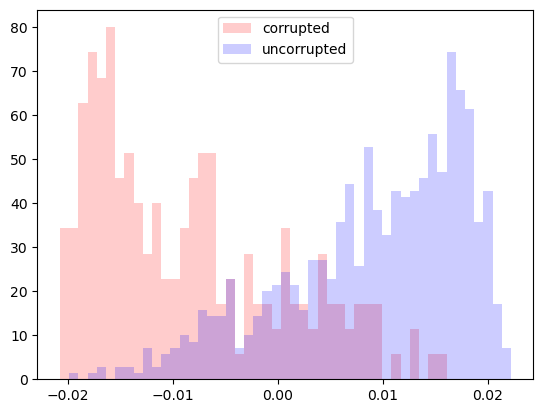

In [ ]:
plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)
plt.hist(vals_dvgs[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvgs[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

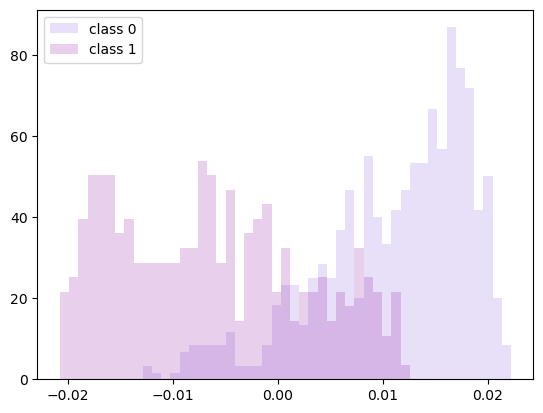

In [ ]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=3)
    plt.hist(vals_dvgs[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

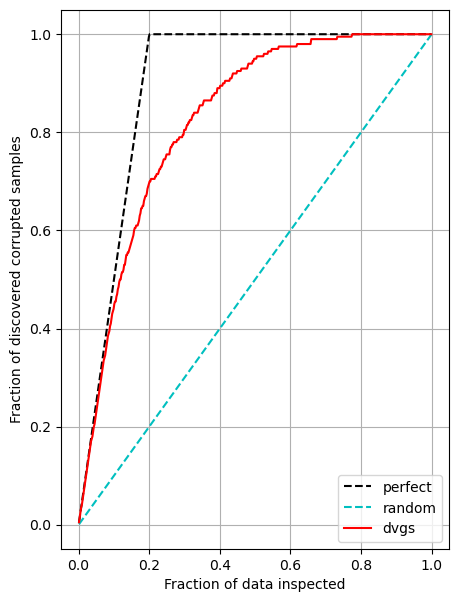

In [ ]:
pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Data Shapley (dshap)

[arxiv](https://arxiv.org/abs/1904.02868)  
[proceedings](https://proceedings.mlr.press/v97/ghorbani19c/ghorbani19c.pdf)  
[github](https://github.com/amiratag/DataShapley) 

```
@inproceedings{ghorbani2019data,
  title={Data Shapley: Equitable Valuation of Data for Machine Learning},
  author={Ghorbani, Amirata and Zou, James},
  booktitle={International Conference on Machine Learning},
  pages={2242--2251},
  year={2019}
}
```

In [ ]:
CEL = torch.nn.CrossEntropyLoss() 

dshap = DShap.DShap(model           = model, 
                    crit            = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)),
                    x_train         = x_train,
                    y_train         = y_train,
                    x_valid         = x_valid,
                    y_valid         = y_valid,
                    perf_metric     = lambda y, yhat: roc_auc_score(y, yhat[:, 1]),
                    epochs          = 100,
                    tol             = 0.03,
                    optim           = torch.optim.Adam,
                    lr              = 1e-3,
                    verbose         = True)

tic = time.time() 
vals_shap = dshap.TMC(max_iterations=500, min_iterations=50, use_cuda=True, T=5, stopping_criteria=0.999)

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

v0 (null model): 0.5149
vD (all data): 0.8685

starting Data Shapley TMC...
iter: 119 || max j: 371 || max vj: 0.8490 || rank_corr: 0.9990
MC stopping criteria met. running avg rank correlation: 0.9990

time elapsed: 347.52 min


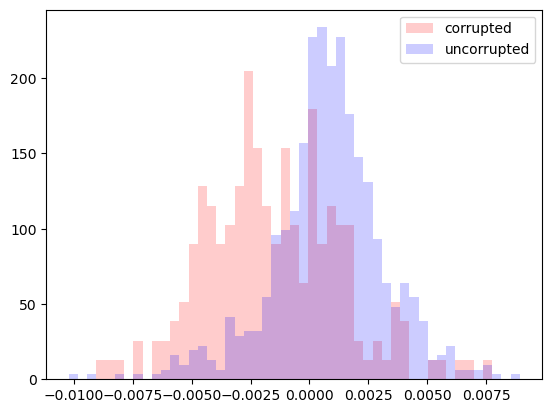

In [ ]:
plt.figure() 
bins = np.linspace(vals_shap.min(), vals_shap.max(), 50)
plt.hist(vals_shap[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_shap[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

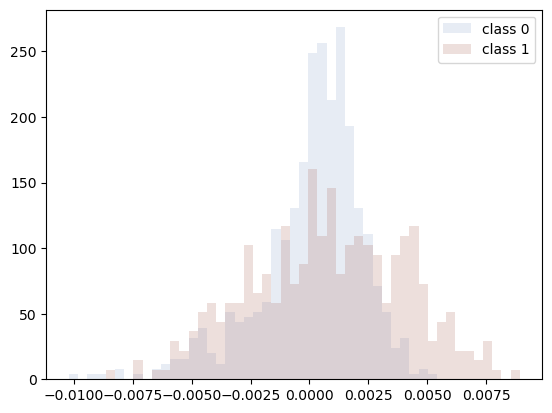

In [ ]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_shap.min(), vals_shap.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_shap[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

(1000,)


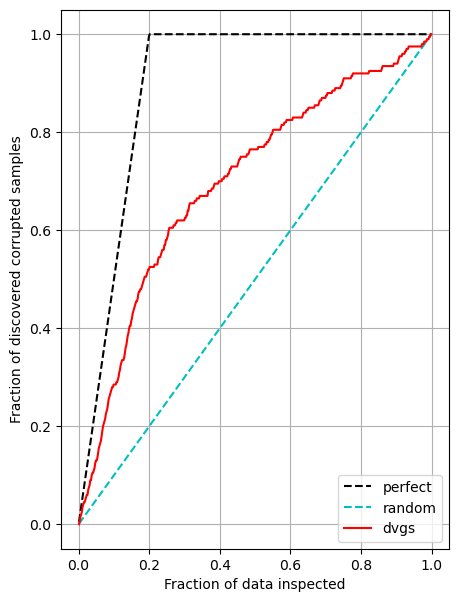

In [ ]:
pk, shap_corr, p_perfect, p_random = get_corruption_scores(vals_shap, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, shap_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Leave-one-out (LOO)



In [ ]:
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)) 
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1])  

loo = LOO(x_train           = x_train,
          y_train           = y_train,
          x_valid           = x_valid,
          y_valid           = y_valid,
          model             = model,
          metric            = metric,
          crit              = crit, 
          optim             = torch.optim.Adam, 
          epochs            = 200, 
          lr                = 1e-4,
          batch_size        = 250, 
          use_cuda          = True, 
          verbose           = True, 
          baseline_repl     = 10,
          n_repl            = 1)

print()  

loo_values = loo.run()
vals_loo = np.array(loo_values)

baseline performance: 0.857 +/- 0.001



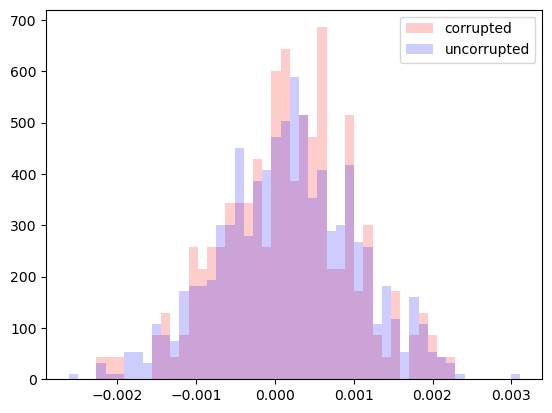

In [ ]:
plt.figure() 
bins = np.linspace(vals_loo.min(), vals_loo.max(), 50)
plt.hist(vals_loo[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_loo[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

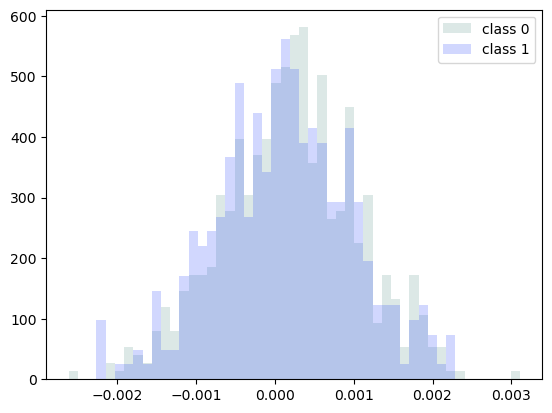

In [ ]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_loo.min(), vals_loo.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_loo[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

(1000,)


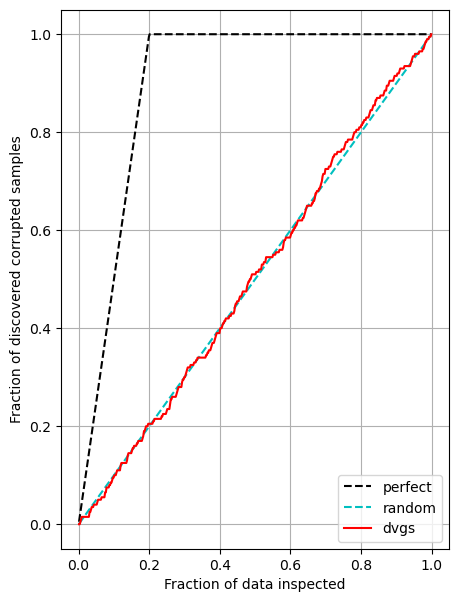

In [ ]:
pk, loo_corr, p_perfect, p_random = get_corruption_scores(vals_loo, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, loo_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Data Valuation with Reinforcement Learning (DVRL)



In [ ]:
#pred = LogisticRegression(108, 2) 

pred = copy.deepcopy(model) 
#pred.reset_parameters()

estimator = Estimator(xin               = 108, 
                      yin               = 4, 
                      y_cat_dim         = 10, 
                      num_layers        = 5, 
                      hidden_channels   = 100, 
                      norm              = False, 
                      dropout           = 0., 
                      act               = torch.nn.ReLU)

dvrl = DVRL(x_train             = x_train,
            y_train             = y_train,
            x_valid             = x_valid,
            y_valid             = y_valid,
            predictor           = pred, 
            estimator           = est, 
            problem             = 'classification',
            include_marginal    = True)

print()

# pretraining...
#dvrl.fit(dvrl.predictor, dvrl.x_train, dvrl.y_train, crit=lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), batch_size=256, lr=1e-4, epochs=500, use_cuda=True)

tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'auroc', 
                     crit_pred              = lambda x,y: torch.nn.functional.cross_entropy(x, y.squeeze(1).type(torch.long)), 
                     outer_iter             = 1000, 
                     inner_iter             = 200, 
                     outer_batch            = 1000, 
                     inner_batch            = 250, 
                     estim_lr               = 1e-2, 
                     pred_lr                = 1e-4, 
                     moving_average_window  = 50,
                     entropy_beta           = 0.1, 
                     entropy_decay          = 1.,
                     fix_baseline           = True,
                     noise_labels           = endog_noise,
                     use_cuda               = False)

vals_dvrl = vals_dvrl.detach().numpy().ravel()

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      


pretraining `ori_model` and `val_model` 
4/4


KeyboardInterrupt: 

In [ ]:
plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_dvrl[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

NameError: name 'np' is not defined

In [ ]:
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(vals_dvrl, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvrl_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

NameError: name 'get_corruption_scores' is not defined

# DVRL2 

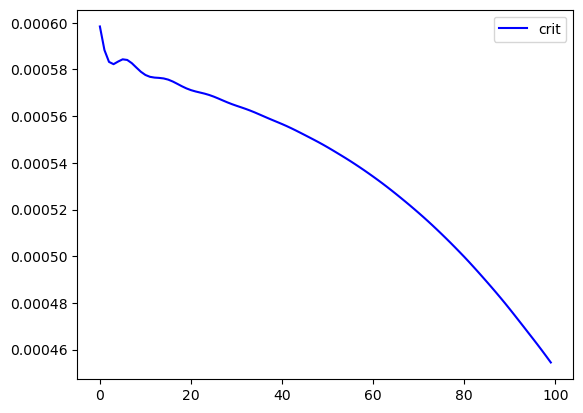

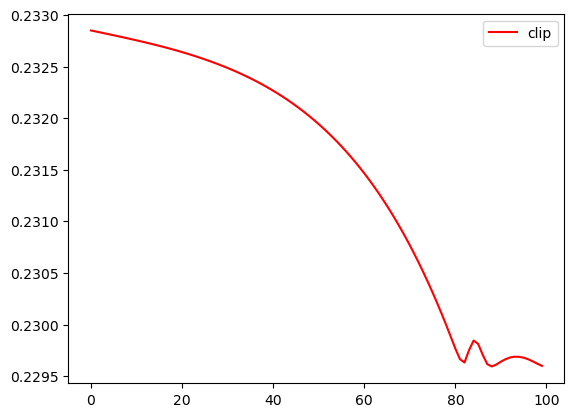

p tensor([0.4111, 0.4110, 0.4095, 0.4019, 0.4119])
v tensor([0.0085, 0.0718, 0.0055, 0.0141, 0.0071])


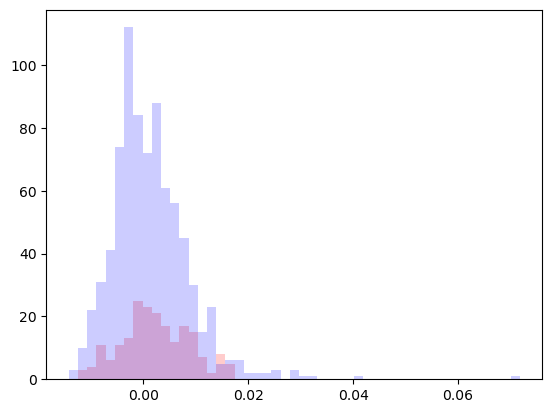

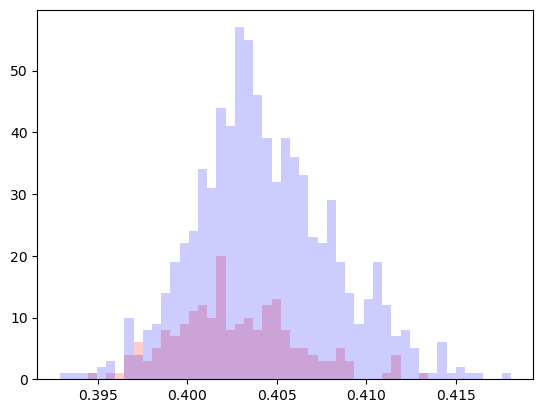

outer iteration: 999 || last perf: 0.7749 || noise auc (vi): 0.44 || noise auc (pi): 0.62|| log entropy beta: -2.00 epoch elapsed: 3.9e+02 s


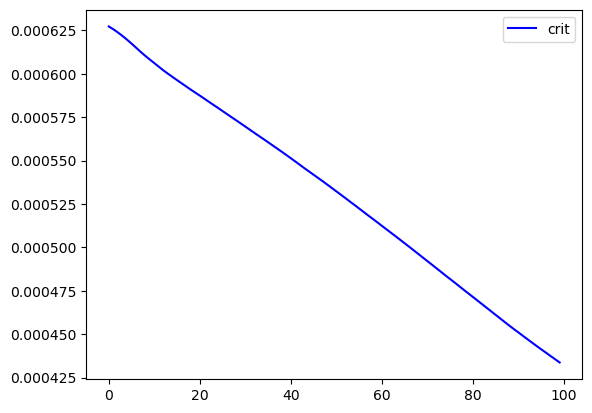

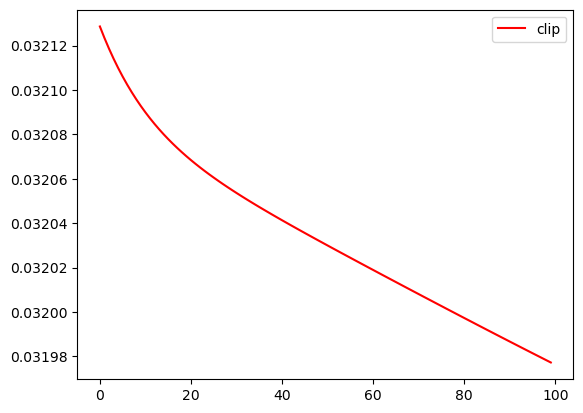

p tensor([0.3818, 0.3864, 0.3815, 0.3763, 0.3794])
v tensor([ 0.0150,  0.0059, -0.0049,  0.0546,  0.0042])


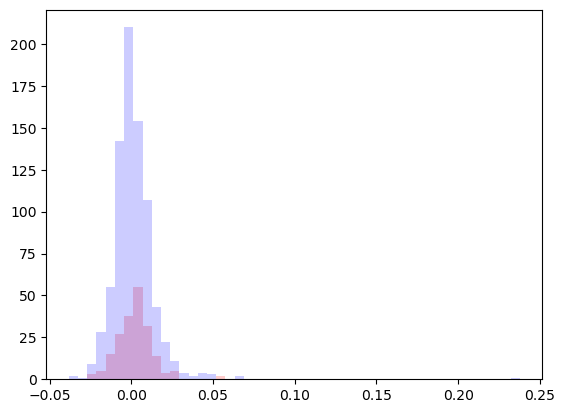

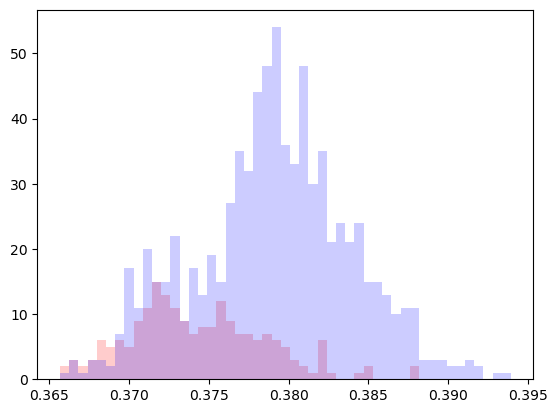

outer iteration: 999 || last perf: 0.7725 || noise auc (vi): 0.46 || noise auc (pi): 0.77|| log entropy beta: -2.00 epoch elapsed: 3.4e+02 s


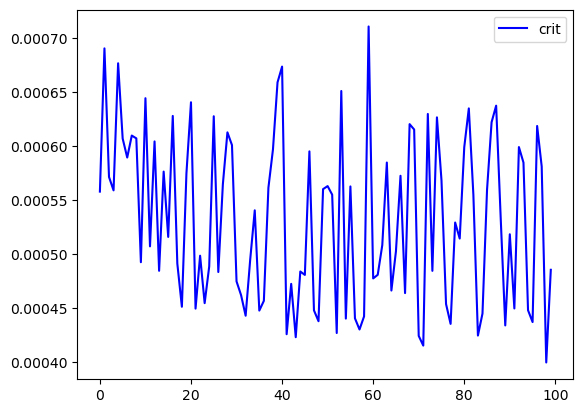

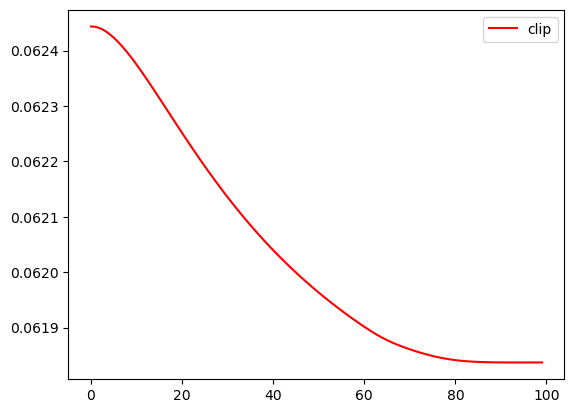

p tensor([0.4609, 0.4560, 0.4562, 0.4600, 0.4601])
v tensor([ 0.0589,  0.0272, -0.0029,  0.0005, -0.0057])


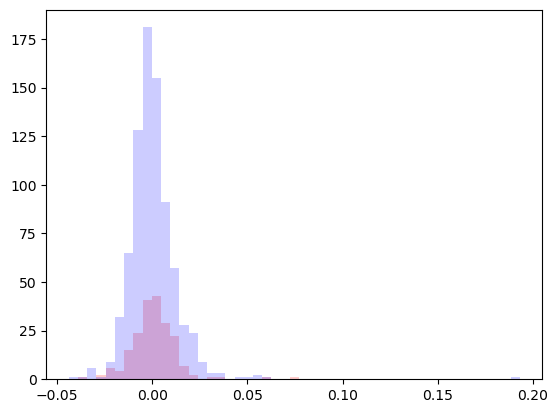

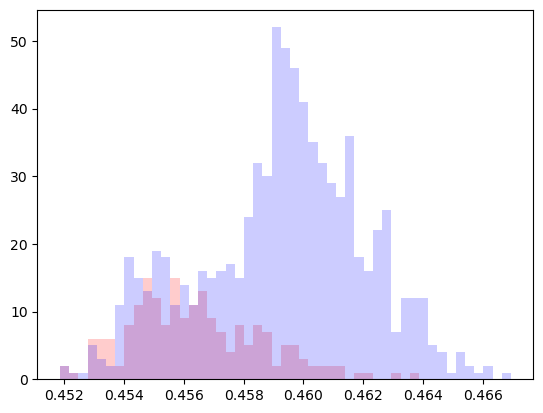

outer iteration: 999 || last perf: 0.7237 || noise auc (vi): 0.47 || noise auc (pi): 0.79|| log entropy beta: -2.00 epoch elapsed: 3.6e+02 s


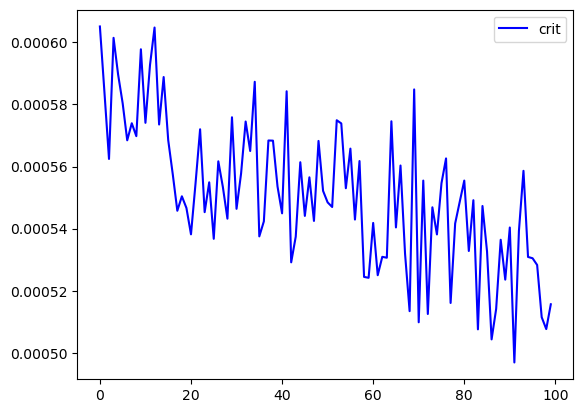

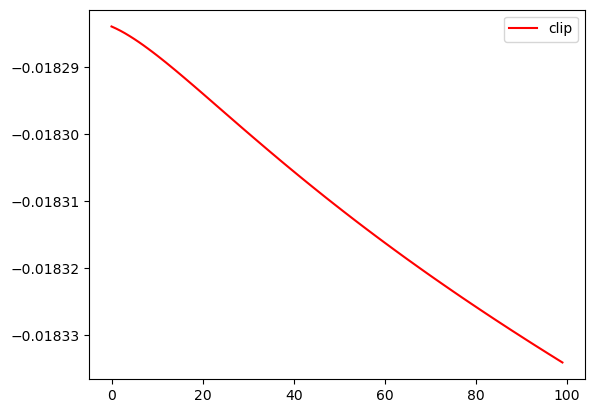

p tensor([0.4722, 0.4754, 0.4748, 0.4757, 0.4733])
v tensor([0.0087, 0.0617, 0.0008, 0.0202, 0.0375])


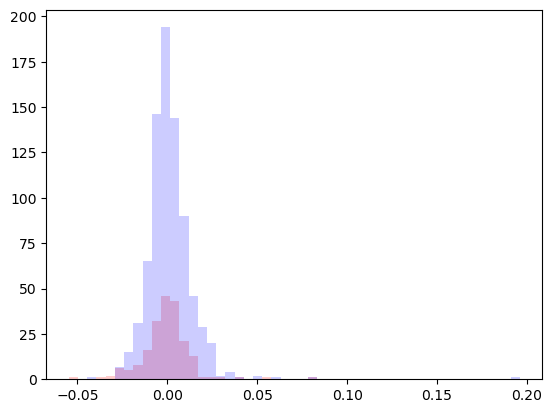

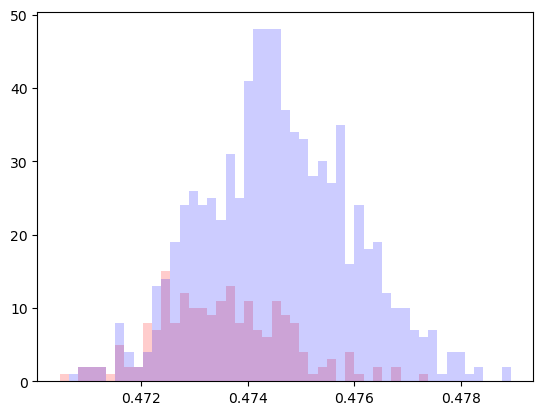

outer iteration: 999 || last perf: 0.7884 || noise auc (vi): 0.53 || noise auc (pi): 0.72|| log entropy beta: -2.00 epoch elapsed: 4.2e+02 s


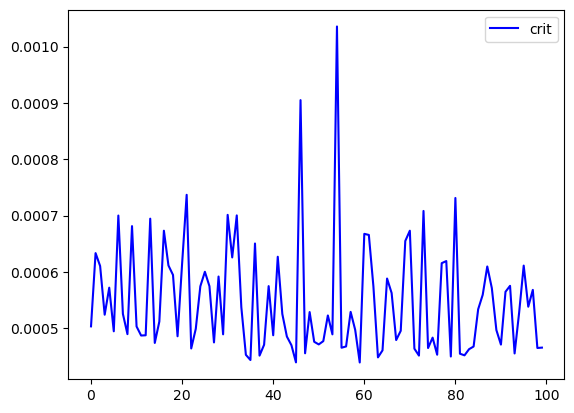

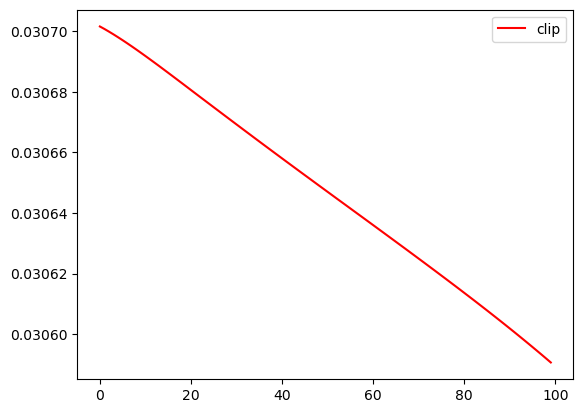

p tensor([0.4931, 0.4925, 0.4938, 0.4924, 0.4944])
v tensor([ 0.0031, -0.0092,  0.0911,  0.0141, -0.0096])


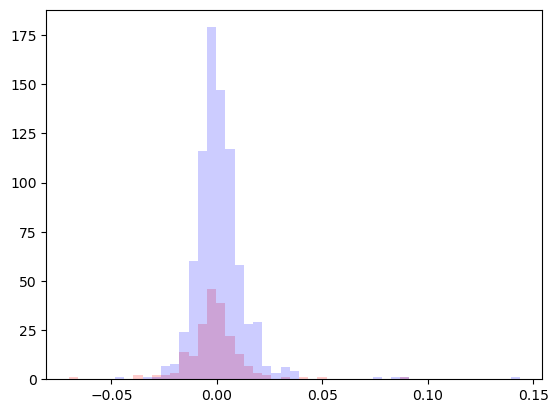

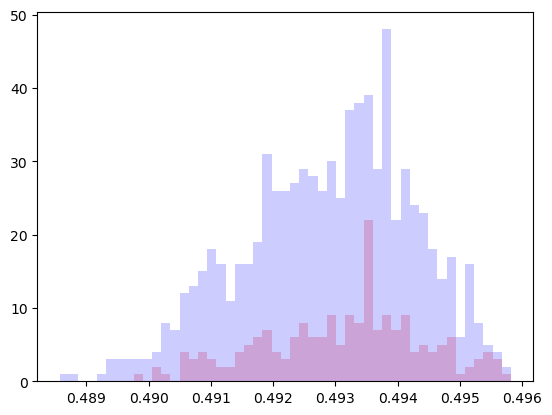

outer iteration: 999 || last perf: 0.7661 || noise auc (vi): 0.54 || noise auc (pi): 0.46|| log entropy beta: -2.00 epoch elapsed: 4.3e+02 s


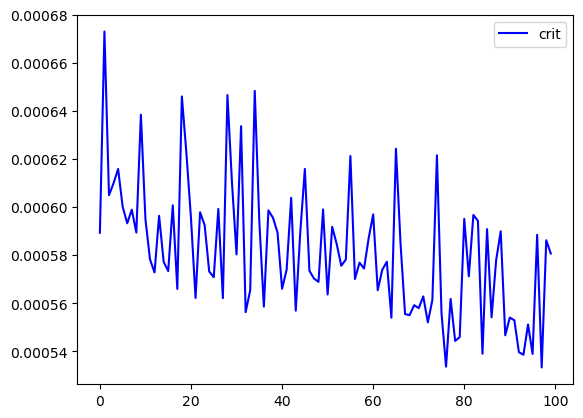

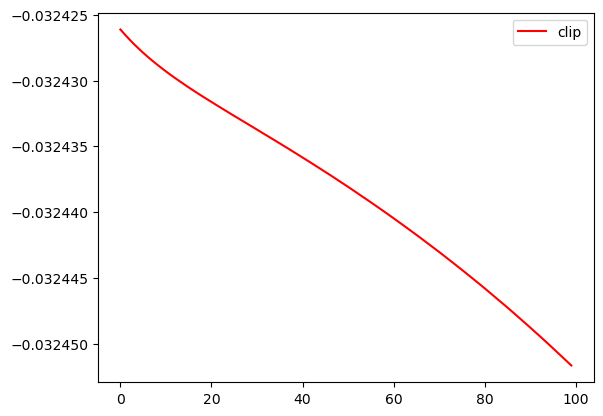

p tensor([0.5090, 0.5016, 0.5078, 0.5006, 0.5105])
v tensor([ 0.0015,  0.0897, -0.0074,  0.0009,  0.0024])


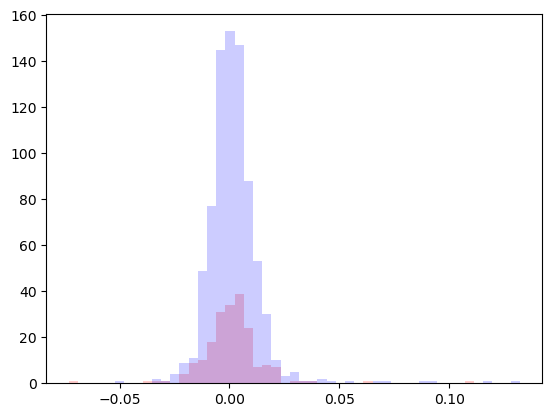

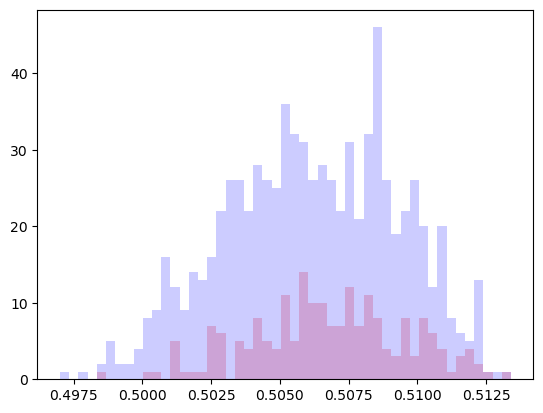

outer iteration: 999 || last perf: 0.7494 || noise auc (vi): 0.51 || noise auc (pi): 0.45|| log entropy beta: -2.00 epoch elapsed: 5.1e+02 s


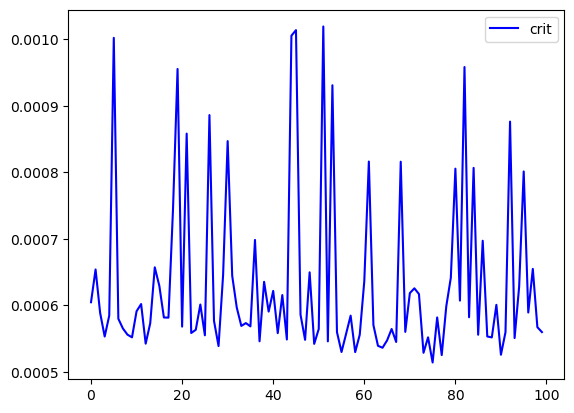

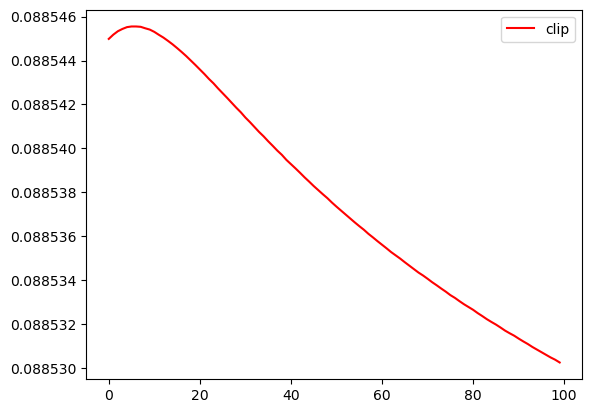

p tensor([0.4915, 0.4949, 0.5004, 0.4954, 0.4967])
v tensor([ 0.0827, -0.0062, -0.0020,  0.0156, -0.0256])


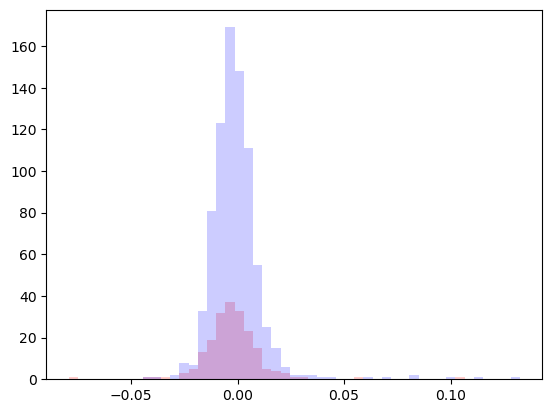

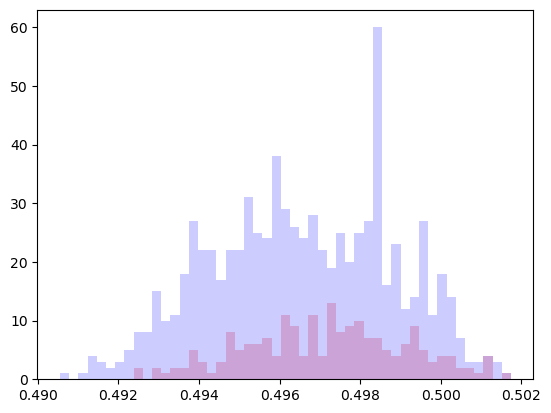

outer iteration: 999 || last perf: 0.7899 || noise auc (vi): 0.53 || noise auc (pi): 0.43|| log entropy beta: -2.00 epoch elapsed: 4.2e+02 s


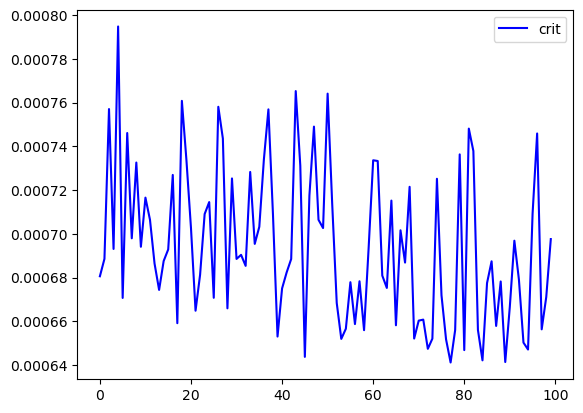

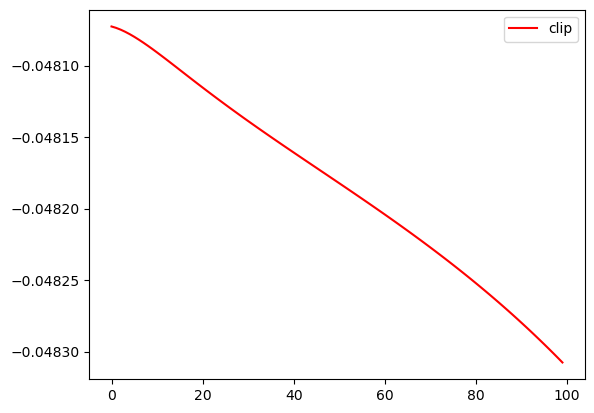

p tensor([0.4693, 0.4670, 0.4707, 0.4704, 0.4689])
v tensor([-0.0183,  0.0157,  0.0061,  0.0034, -0.0014])


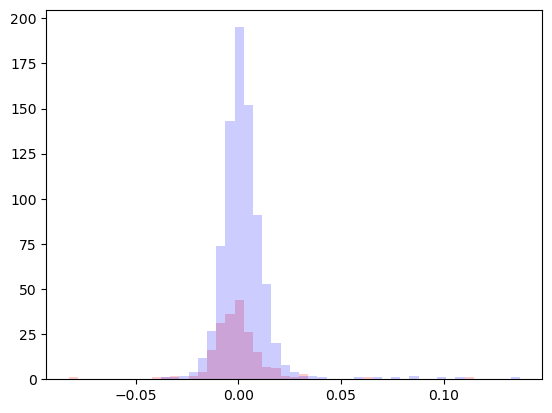

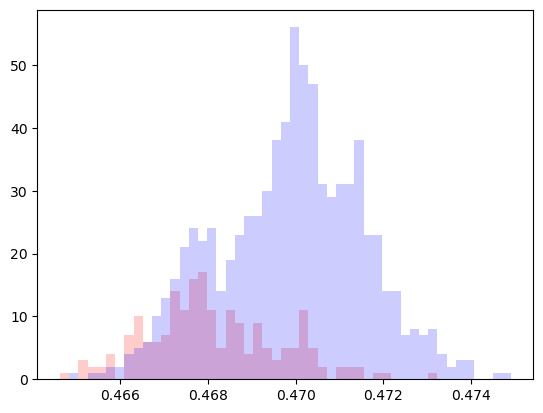

outer iteration: 999 || last perf: 0.7467 || noise auc (vi): 0.59 || noise auc (pi): 0.78|| log entropy beta: -2.00 epoch elapsed: 3e+02 s


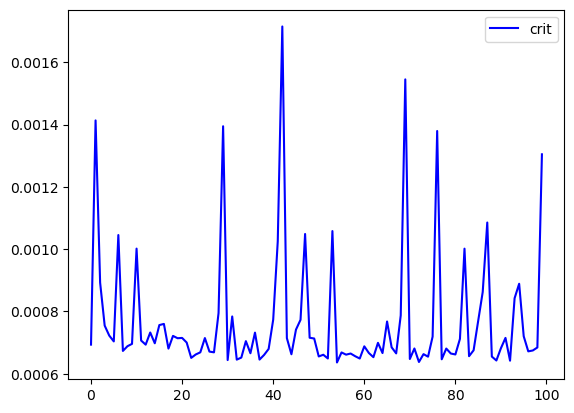

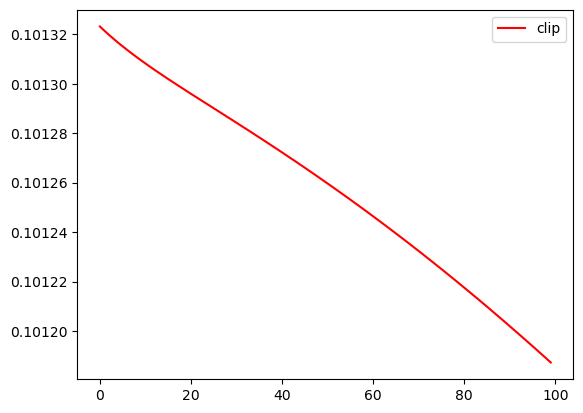

p tensor([0.4467, 0.4310, 0.4458, 0.4481, 0.4346])
v tensor([-0.0022,  0.0132,  0.0151,  0.0142,  0.1297])


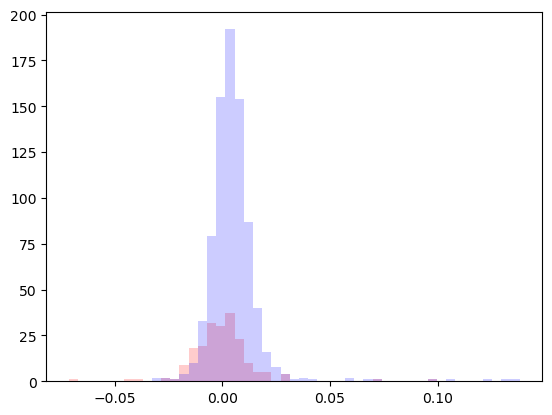

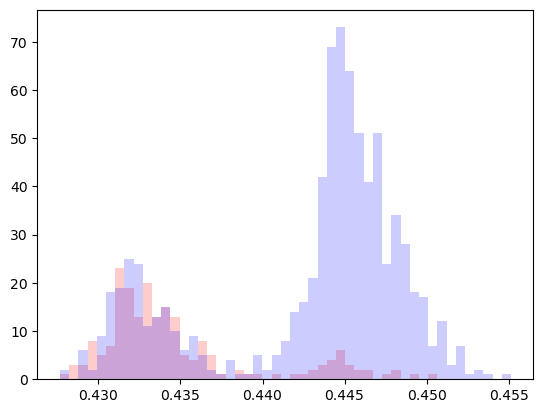

outer iteration: 999 || last perf: 0.7707 || noise auc (vi): 0.64 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 4.2e+02 s


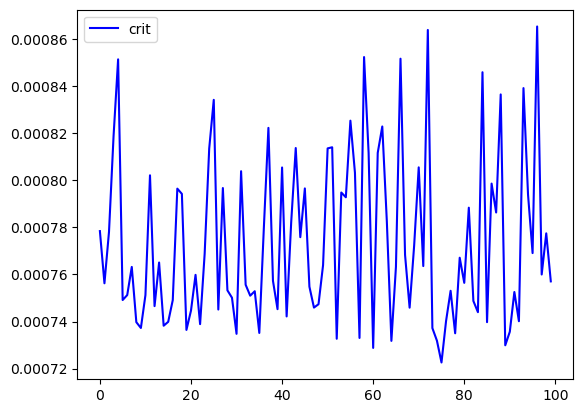

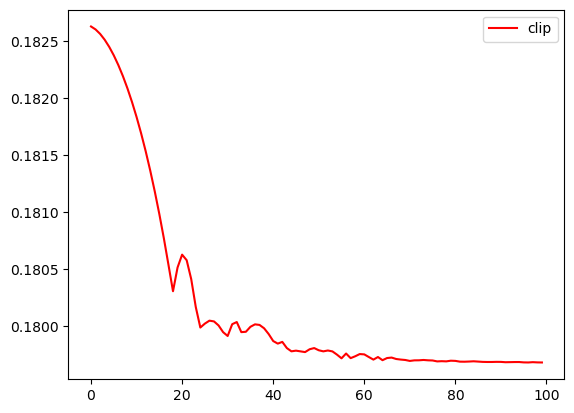

p tensor([0.3598, 0.3465, 0.3569, 0.3559, 0.3479])
v tensor([ 0.0062, -0.0102,  0.0008,  0.0078,  0.0026])


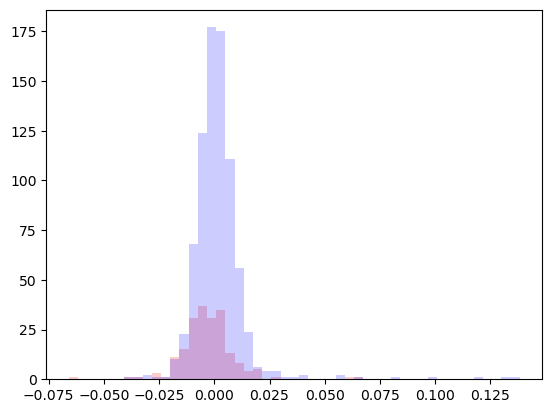

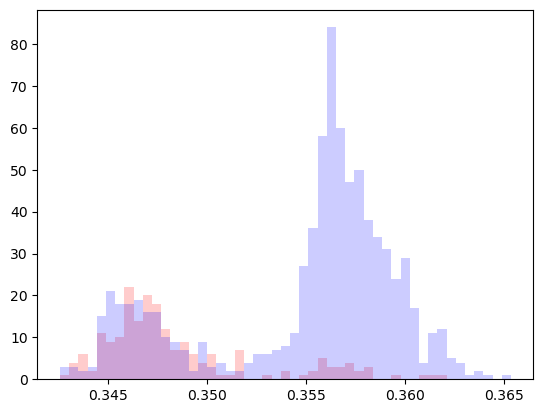

outer iteration: 999 || last perf: 0.8023 || noise auc (vi): 0.63 || noise auc (pi): 0.81|| log entropy beta: -2.00 epoch elapsed: 4e+02 s


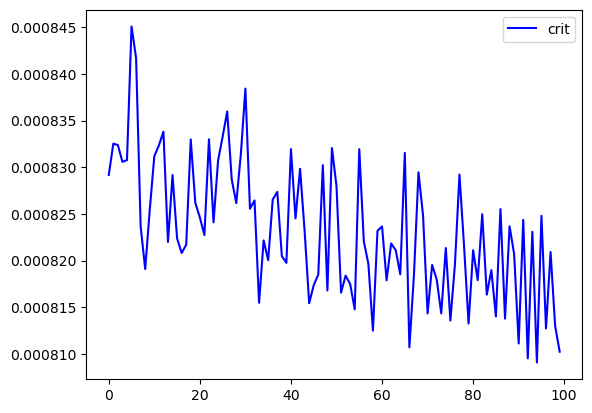

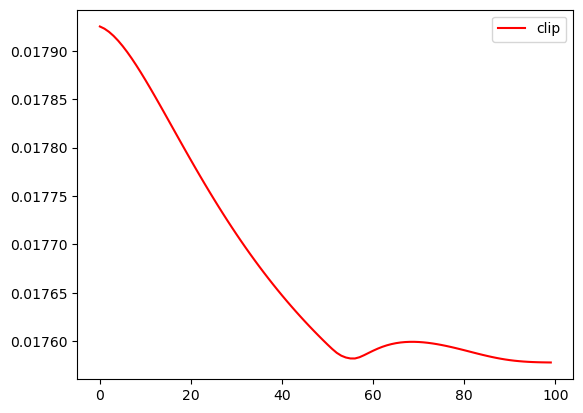

p tensor([0.4266, 0.4315, 0.4160, 0.4176, 0.4285])
v tensor([ 0.0362,  0.0110, -0.0021, -0.0021, -0.0012])


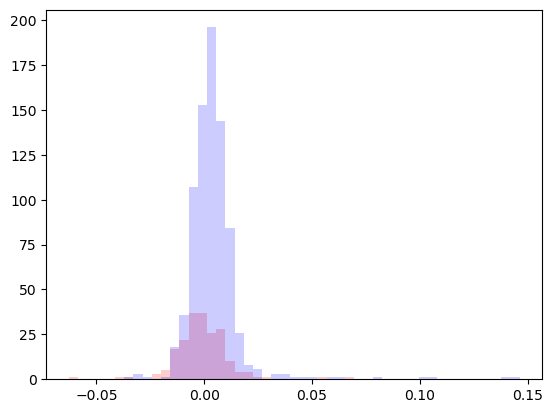

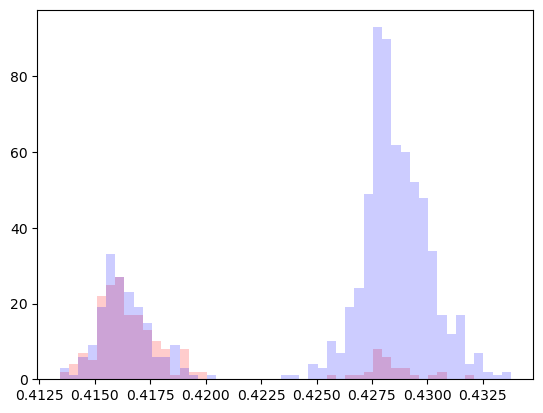

outer iteration: 999 || last perf: 0.7940 || noise auc (vi): 0.64 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 3.3e+02 s


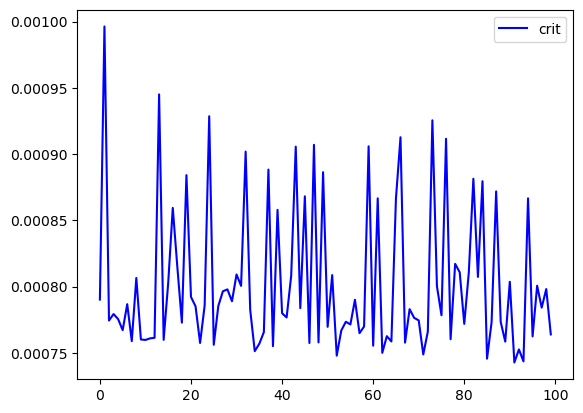

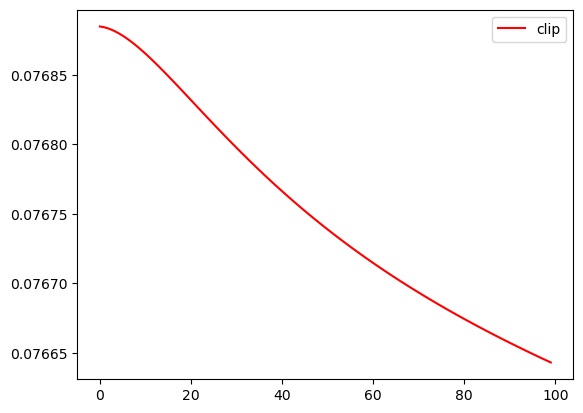

p tensor([0.4715, 0.4708, 0.4599, 0.4732, 0.4719])
v tensor([ 0.0377,  0.0075,  0.0024,  0.0005, -0.0067])


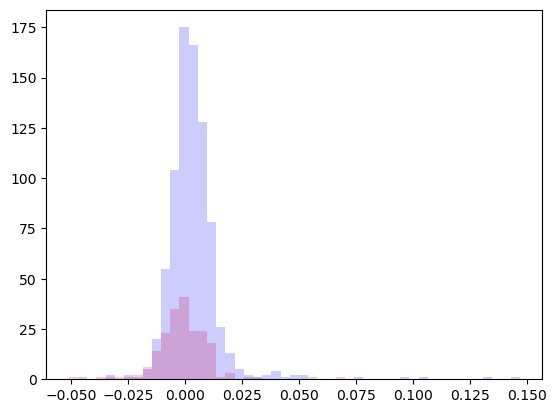

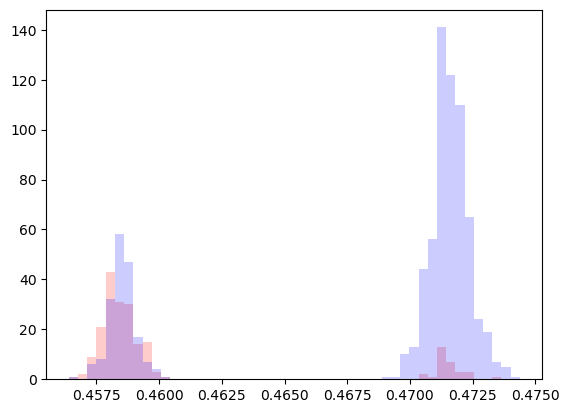

outer iteration: 999 || last perf: 0.7397 || noise auc (vi): 0.62 || noise auc (pi): 0.83|| log entropy beta: -2.00 epoch elapsed: 4e+02 s


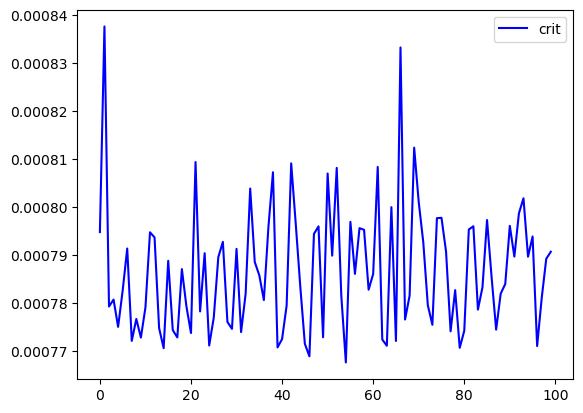

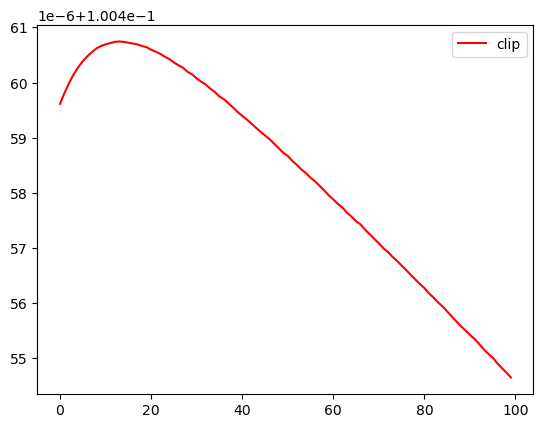

p tensor([0.4765, 0.4574, 0.4763, 0.4573, 0.4758])
v tensor([ 0.0125, -0.0009,  0.0011,  0.0031,  0.0157])


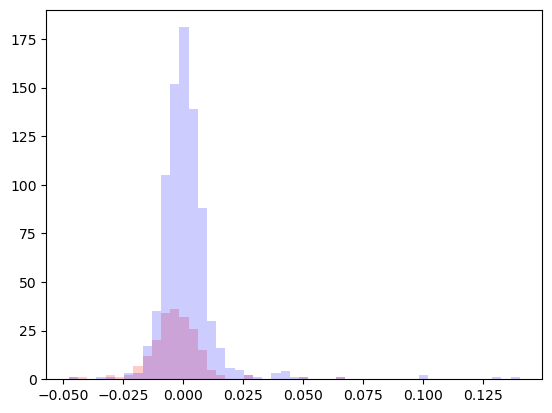

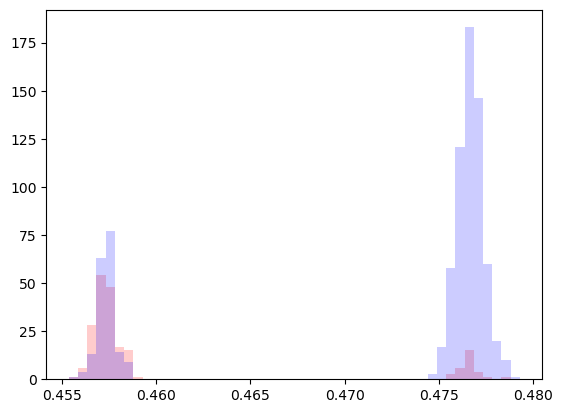

outer iteration: 999 || last perf: 0.7740 || noise auc (vi): 0.63 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 4.5e+02 s


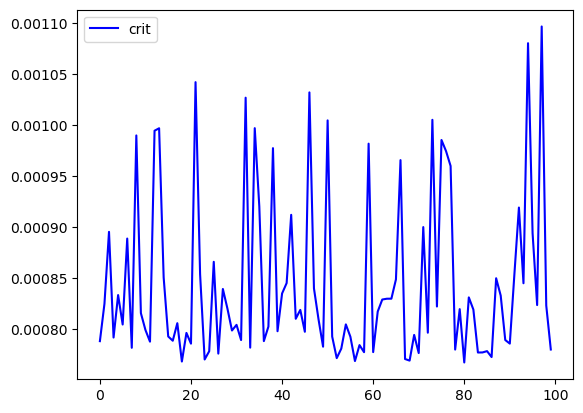

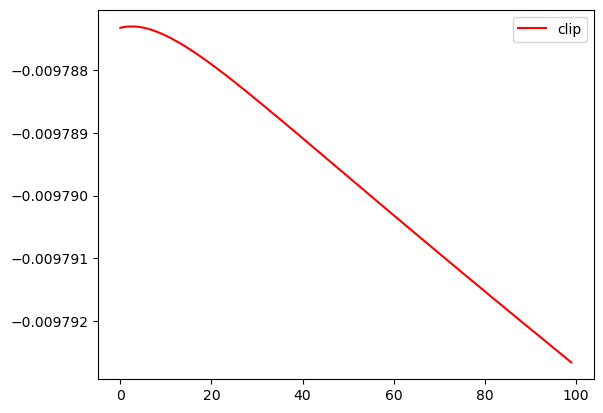

p tensor([0.4549, 0.4737, 0.4731, 0.4727, 0.4734])
v tensor([ 0.0075, -0.0023,  0.0893, -0.0161,  0.0036])


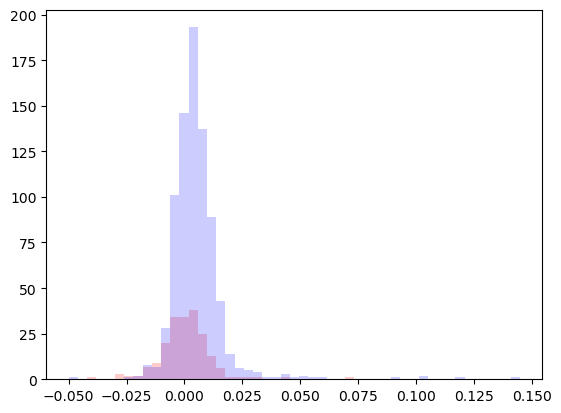

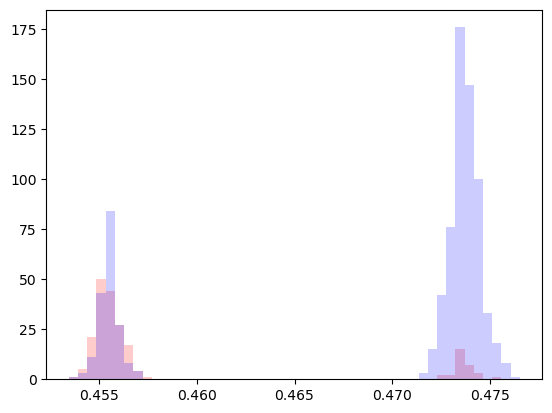

outer iteration: 999 || last perf: 0.7849 || noise auc (vi): 0.64 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 4.2e+02 s


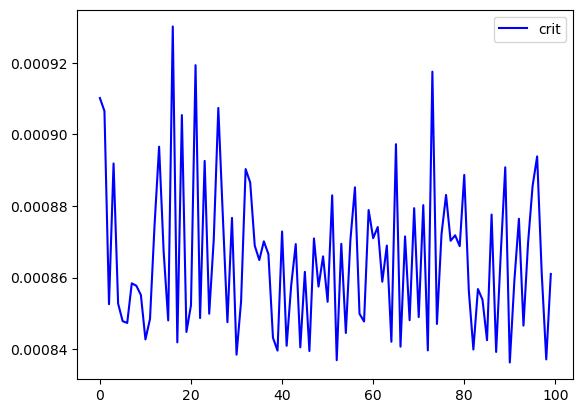

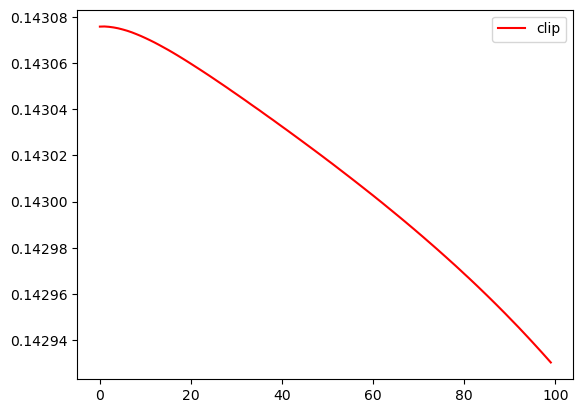

p tensor([0.5018, 0.4686, 0.5019, 0.5024, 0.4684])
v tensor([0.0272, 0.0017, 0.0010, 0.0071, 0.0180])


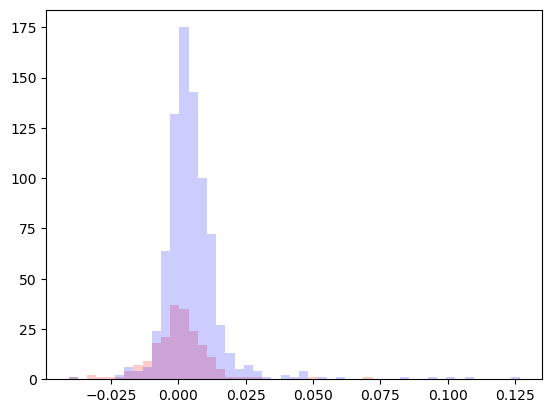

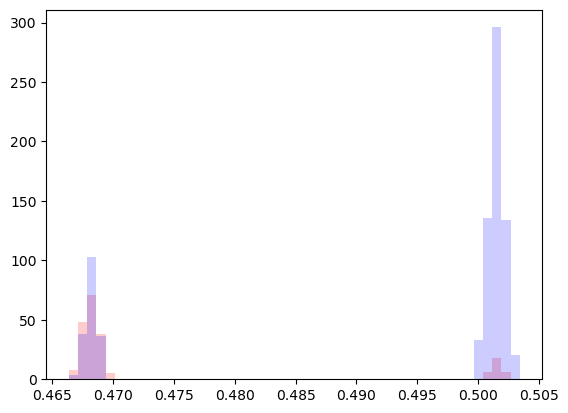

outer iteration: 999 || last perf: 0.7235 || noise auc (vi): 0.64 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 5e+02 s


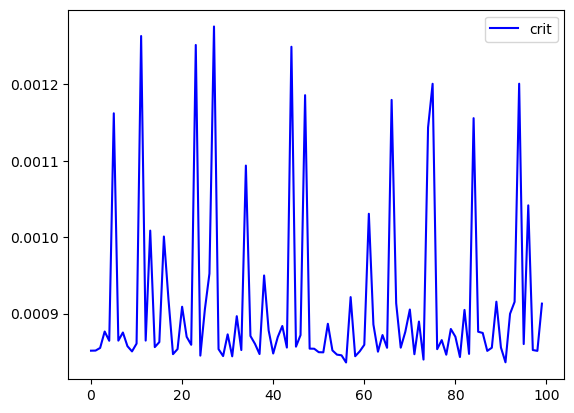

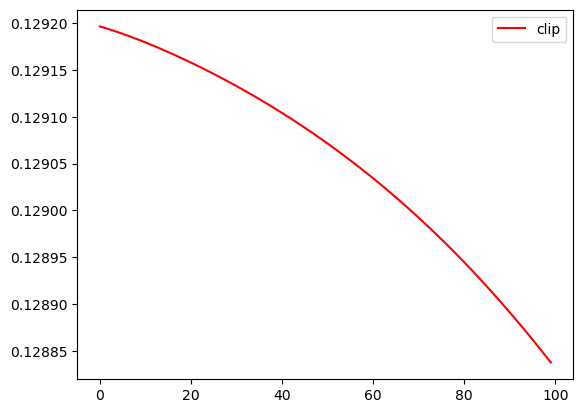

p tensor([0.4335, 0.4317, 0.4293, 0.5539, 0.5533])
v tensor([-0.0024,  0.0102,  0.0531,  0.0004,  0.0099])


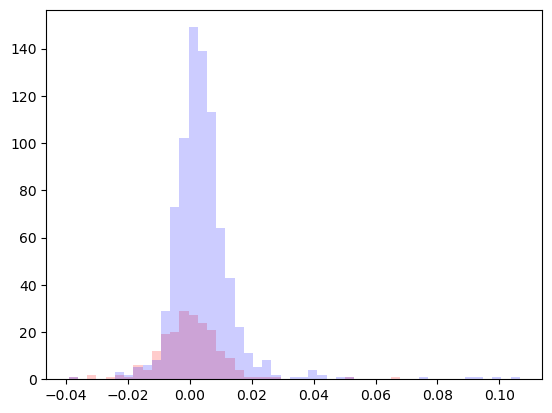

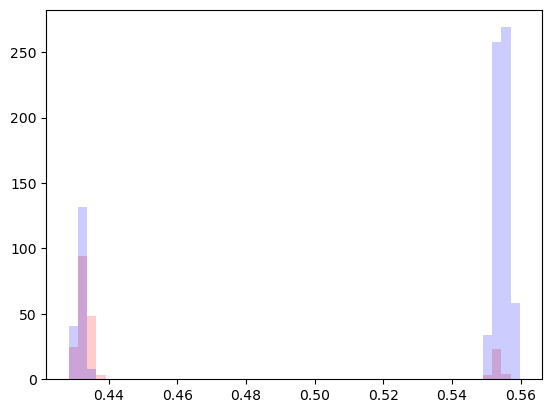

outer iteration: 999 || last perf: 0.7201 || noise auc (vi): 0.62 || noise auc (pi): 0.80|| log entropy beta: -2.00 epoch elapsed: 2.8e+02 s


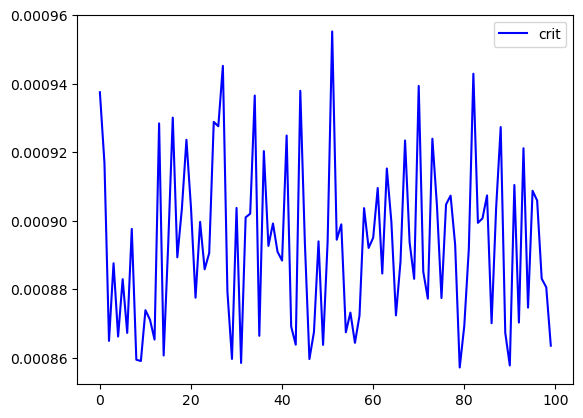

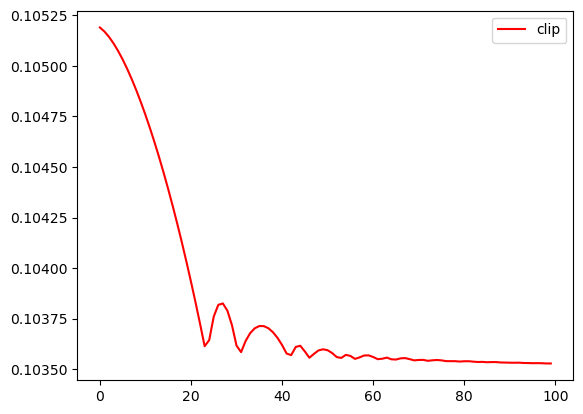

p tensor([0.3431, 0.3467, 0.5166, 0.5163, 0.3473])
v tensor([ 0.0046, -0.0122,  0.0013,  0.0056,  0.0066])


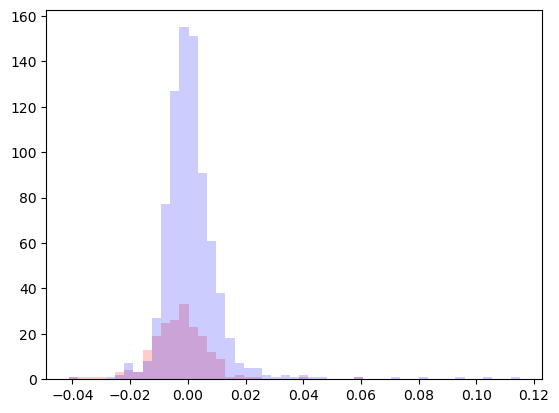

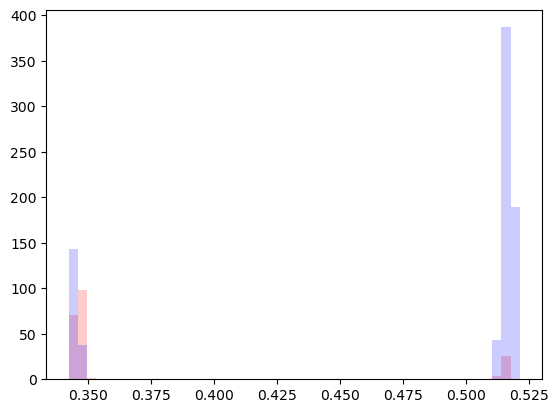

outer iteration: 999 || last perf: 0.7800 || noise auc (vi): 0.62 || noise auc (pi): 0.79|| log entropy beta: -2.00 epoch elapsed: 3.3e+02 s


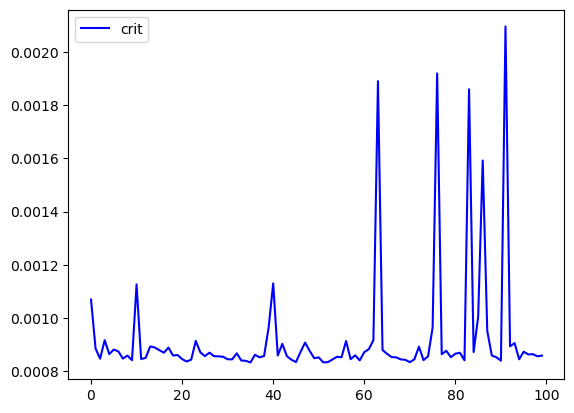

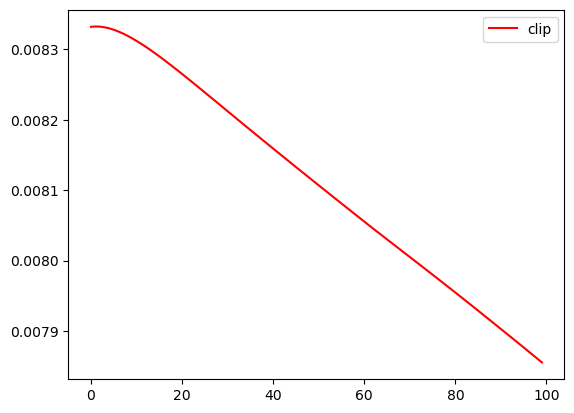

p tensor([0.5930, 0.5922, 0.5899, 0.4101, 0.5958])
v tensor([ 0.0330, -0.0142,  0.0187, -0.0221, -0.0092])


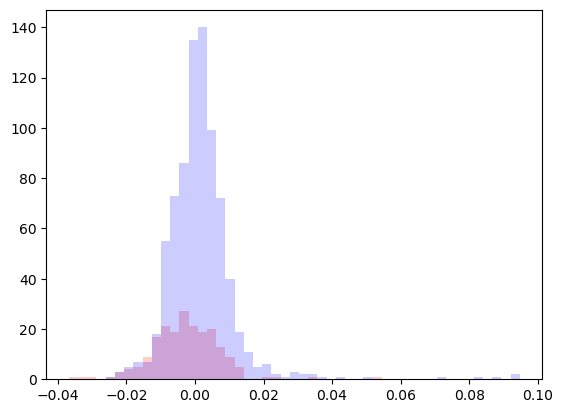

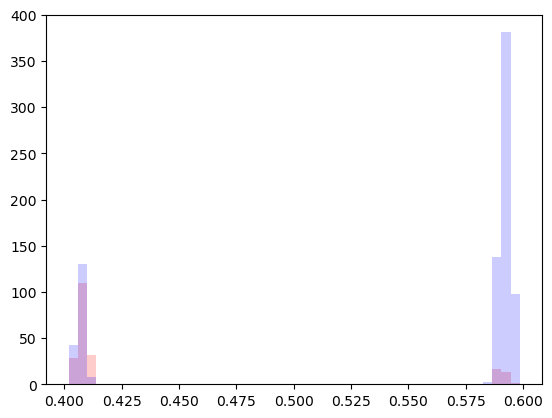

outer iteration: 999 || last perf: 0.8076 || noise auc (vi): 0.63 || noise auc (pi): 0.80|| log entropy beta: -2.00 epoch elapsed: 2.8e+02 s


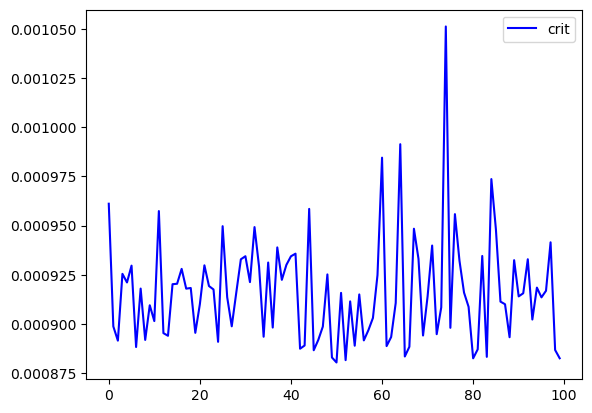

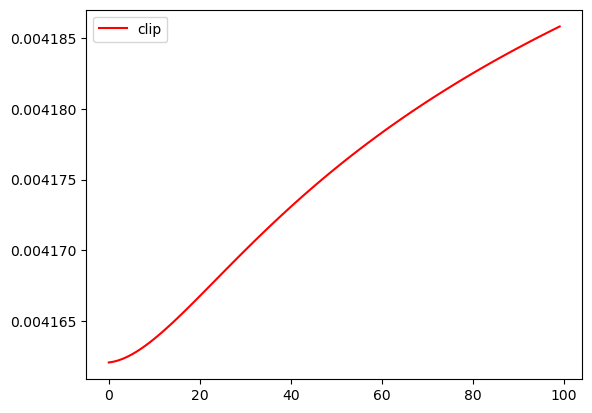

p tensor([0.5611, 0.5629, 0.5646, 0.4166, 0.4206])
v tensor([ 0.0546,  0.0005,  0.0045, -0.0009, -0.0027])


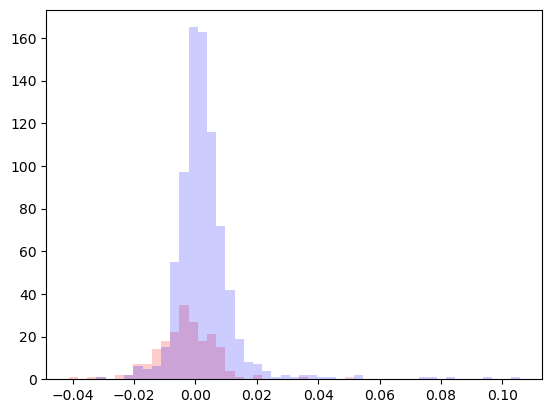

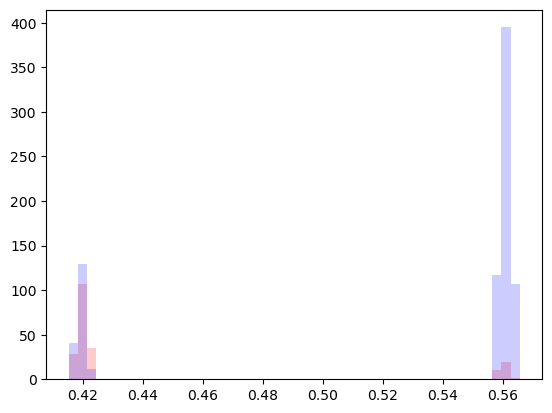

outer iteration: 999 || last perf: 0.8099 || noise auc (vi): 0.68 || noise auc (pi): 0.81|| log entropy beta: -2.00 epoch elapsed: 4e+02 s


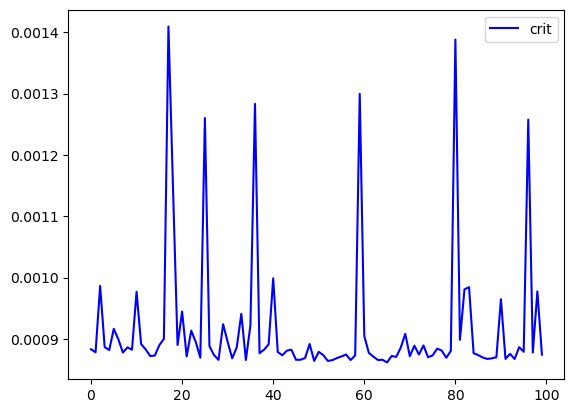

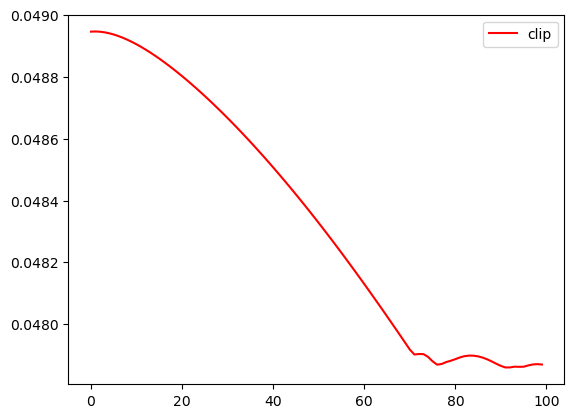

p tensor([0.3370, 0.6459, 0.6449, 0.6506, 0.3349])
v tensor([ 0.0220, -0.0192,  0.0062,  0.0052,  0.0060])


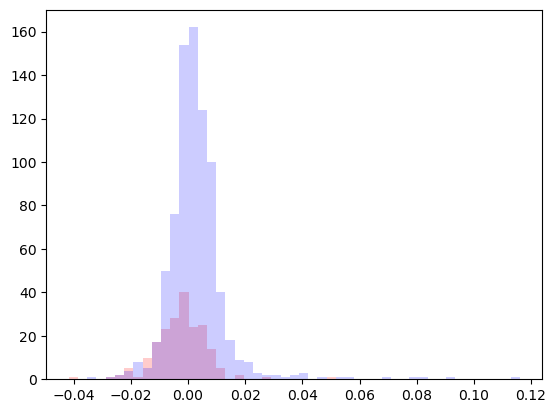

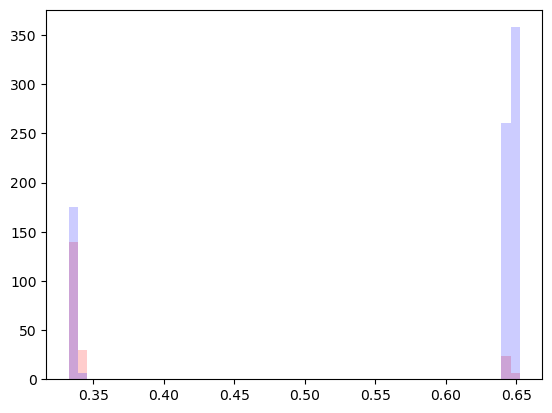

outer iteration: 999 || last perf: 0.7709 || noise auc (vi): 0.66 || noise auc (pi): 0.80|| log entropy beta: -2.00 epoch elapsed: 3.7e+02 s


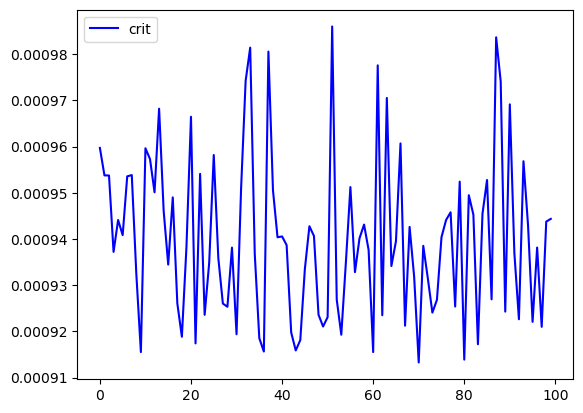

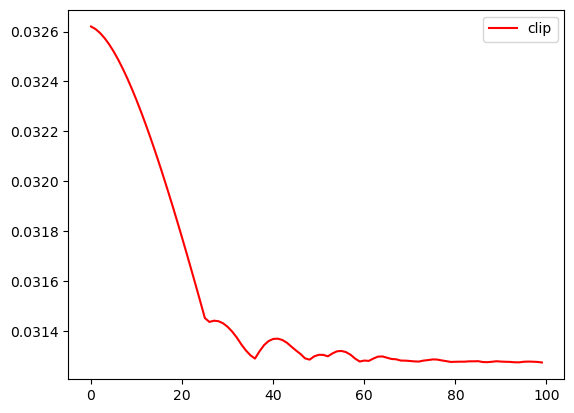

p tensor([0.2711, 0.2691, 0.7160, 0.2708, 0.7150])
v tensor([ 0.0026,  0.0091, -0.0035,  0.0354, -0.0181])


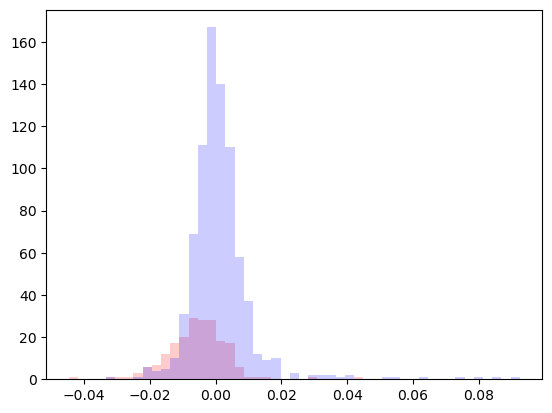

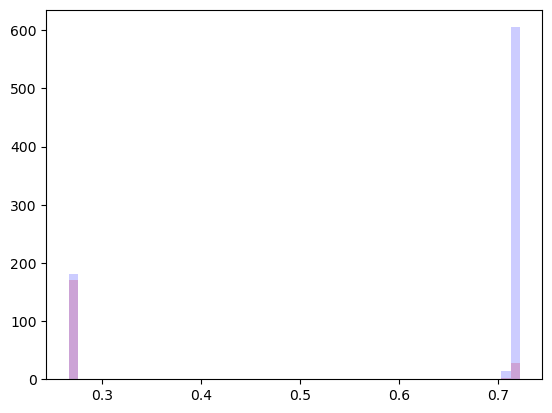

outer iteration: 999 || last perf: 0.7514 || noise auc (vi): 0.72 || noise auc (pi): 0.80|| log entropy beta: -2.00 epoch elapsed: 3.8e+02 s


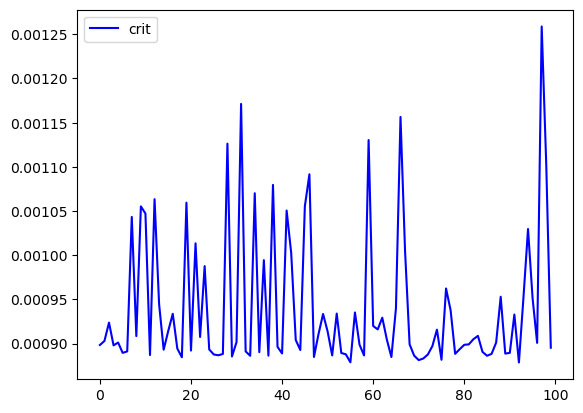

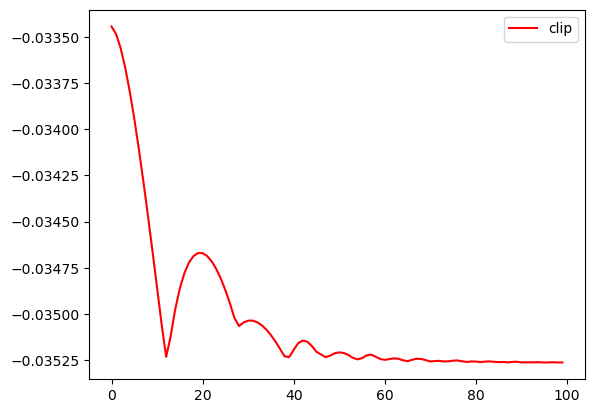

p tensor([0.6559, 0.3234, 0.6614, 0.6614, 0.6613])
v tensor([ 0.0248,  0.0608, -0.0019,  0.0003,  0.0016])


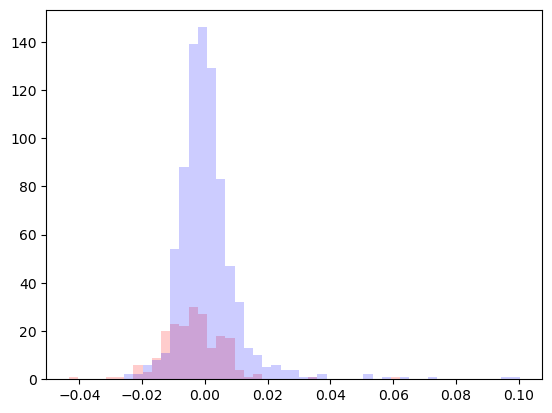

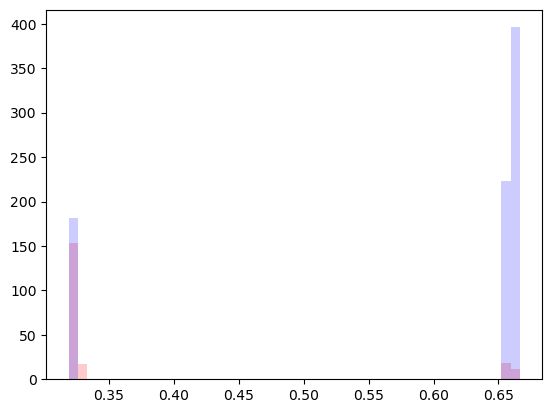

outer iteration: 999 || last perf: 0.7607 || noise auc (vi): 0.63 || noise auc (pi): 0.80|| log entropy beta: -2.00 epoch elapsed: 4.2e+02 s


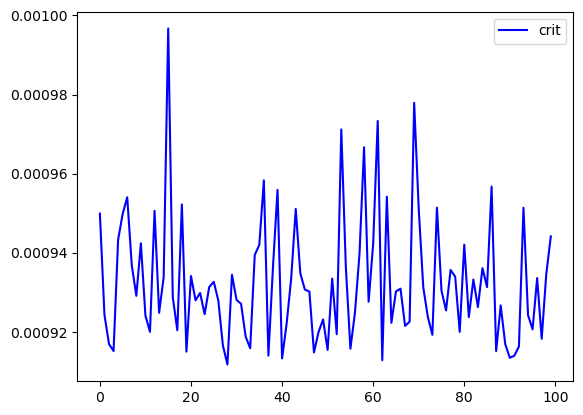

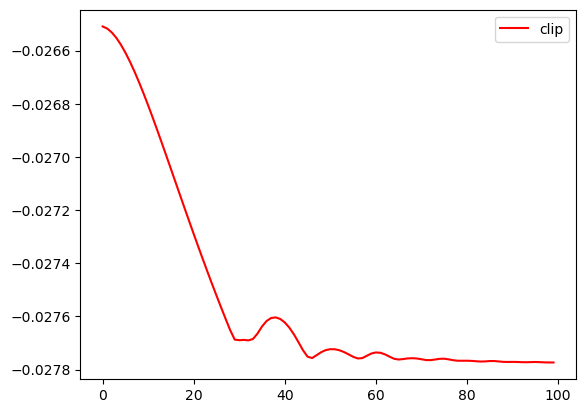

p tensor([0.5916, 0.5943, 0.3870, 0.5933, 0.5938])
v tensor([ 0.0006,  0.0171,  0.0092,  0.0022, -0.0036])


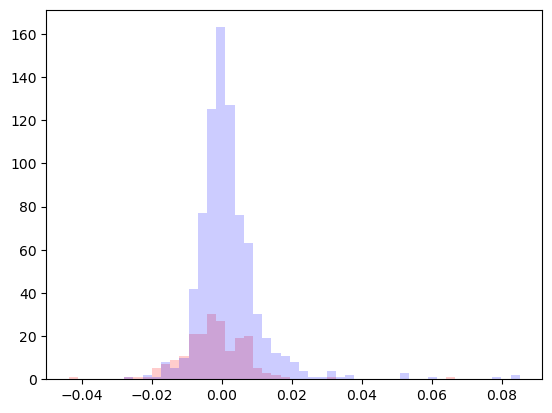

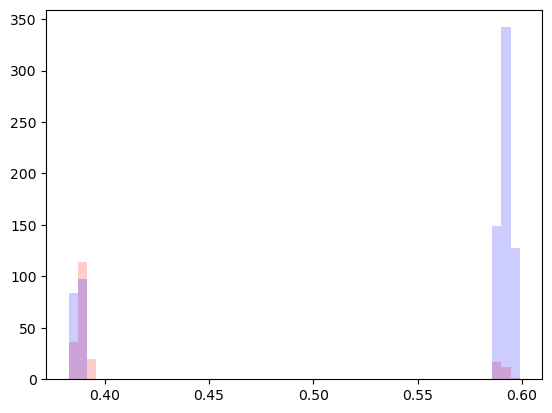

outer iteration: 999 || last perf: 0.7940 || noise auc (vi): 0.62 || noise auc (pi): 0.80|| log entropy beta: -2.00 epoch elapsed: 4.4e+02 s


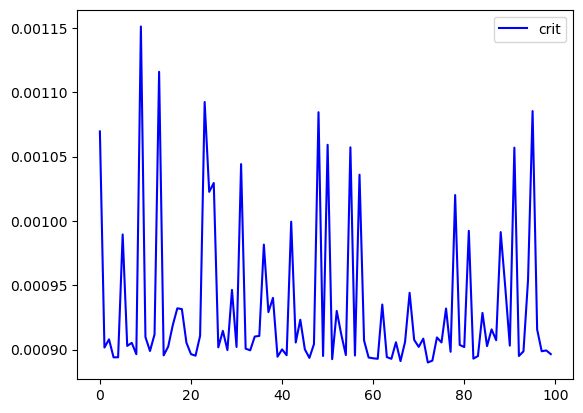

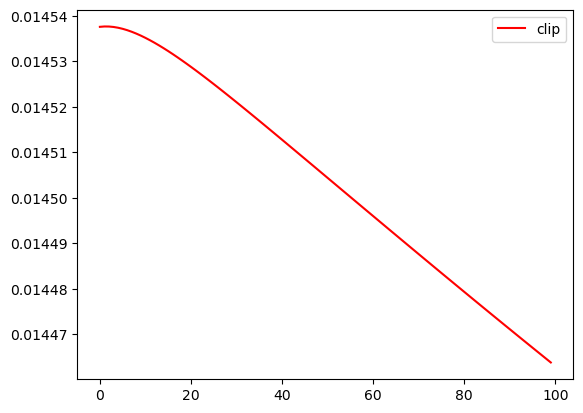

p tensor([0.5933, 0.3721, 0.5984, 0.3678, 0.3637])
v tensor([-0.0039, -0.0141, -0.0041, -0.0140,  0.0027])


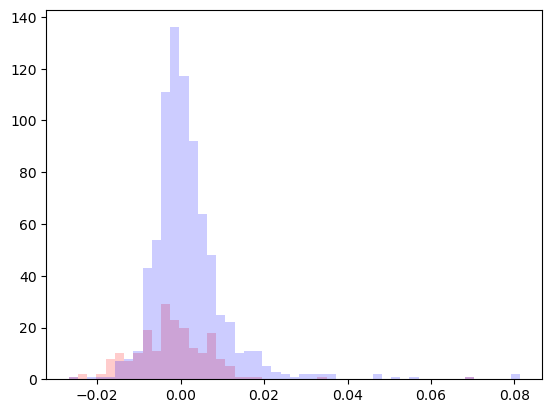

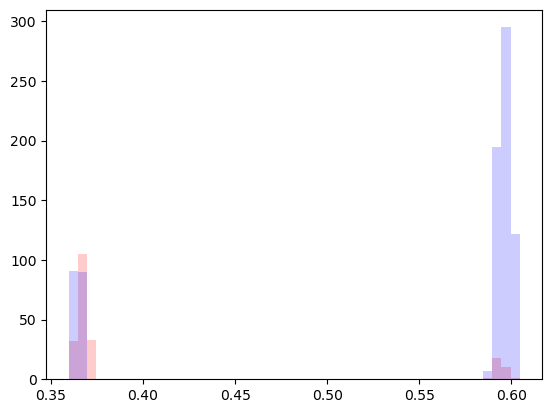

outer iteration: 999 || last perf: 0.7682 || noise auc (vi): 0.62 || noise auc (pi): 0.79|| log entropy beta: -2.00 epoch elapsed: 4.3e+02 s


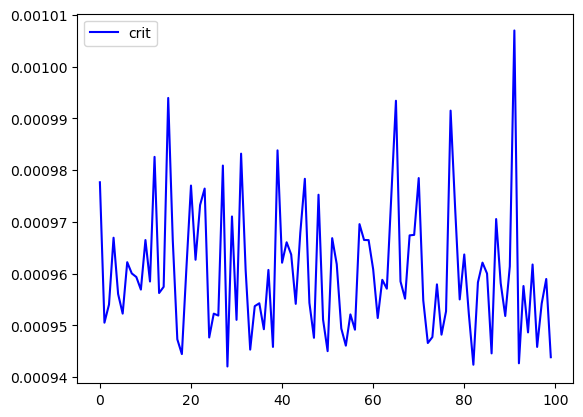

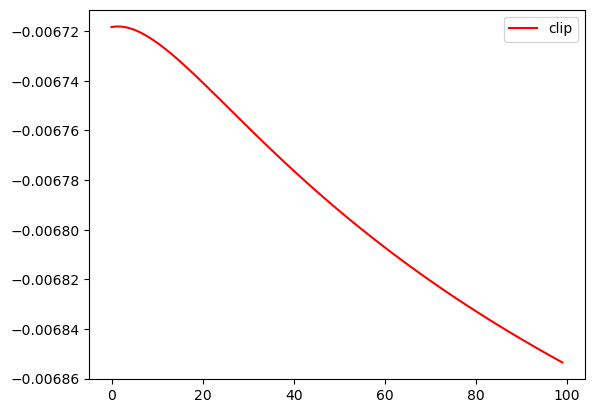

p tensor([0.5628, 0.5661, 0.4236, 0.5635, 0.4242])
v tensor([-0.0001,  0.0131,  0.0348,  0.0002, -0.0012])


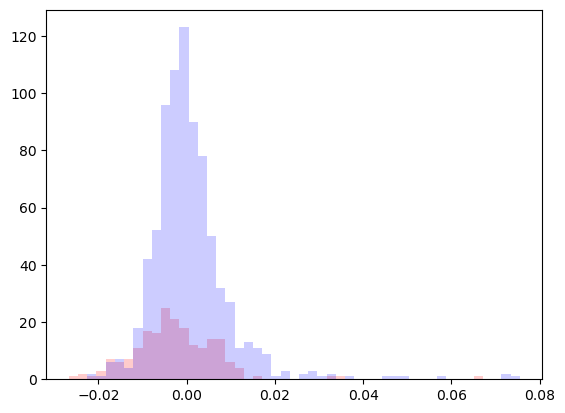

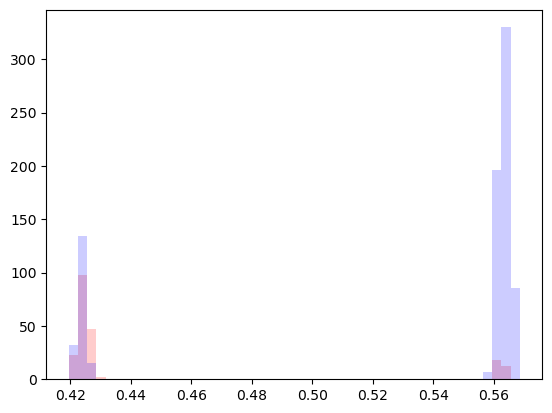

outer iteration: 999 || last perf: 0.7317 || noise auc (vi): 0.61 || noise auc (pi): 0.81|| log entropy beta: -2.00 epoch elapsed: 3.3e+02 s


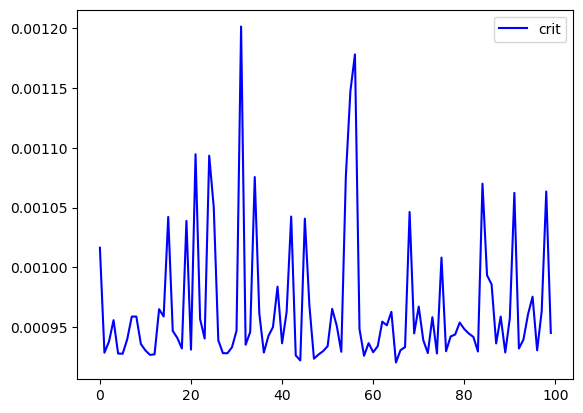

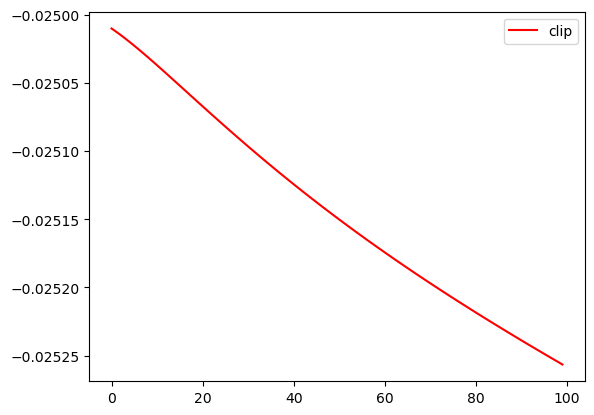

p tensor([0.5283, 0.5279, 0.5295, 0.5277, 0.5274])
v tensor([-0.0016,  0.0003,  0.0159,  0.0004, -0.0113])


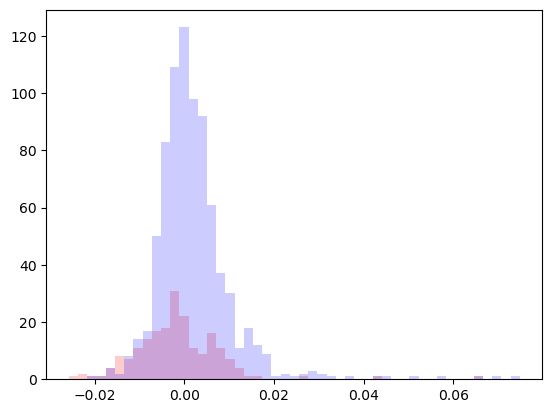

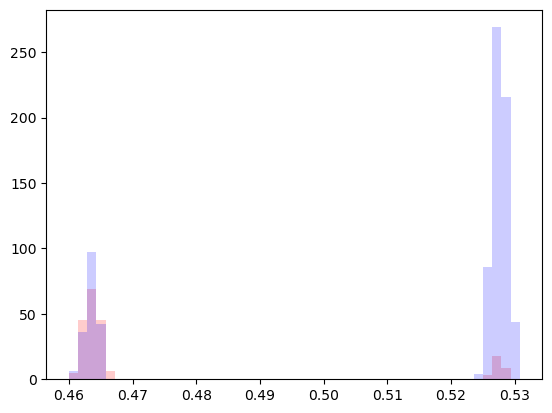

outer iteration: 999 || last perf: 0.7700 || noise auc (vi): 0.63 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 3.8e+02 s


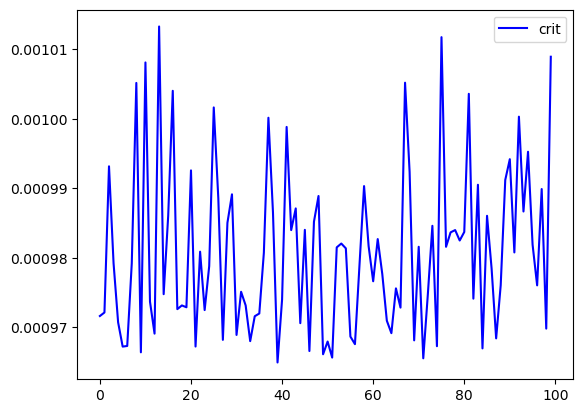

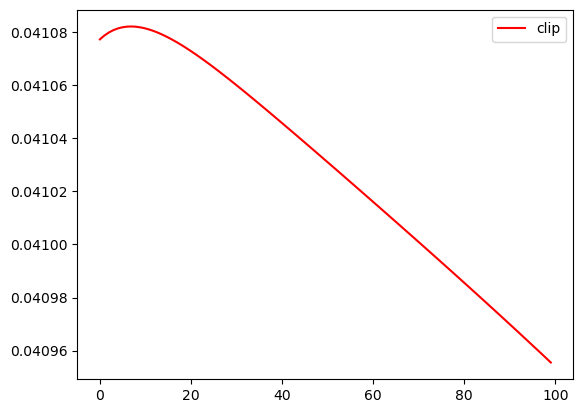

p tensor([0.4613, 0.4625, 0.4611, 0.4597, 0.4619])
v tensor([ 0.0187,  0.0013, -0.0062, -0.0030,  0.0024])


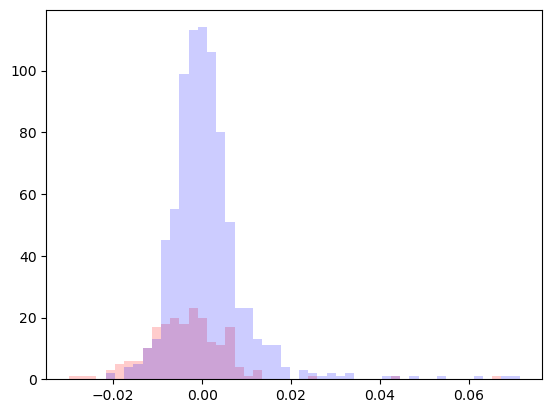

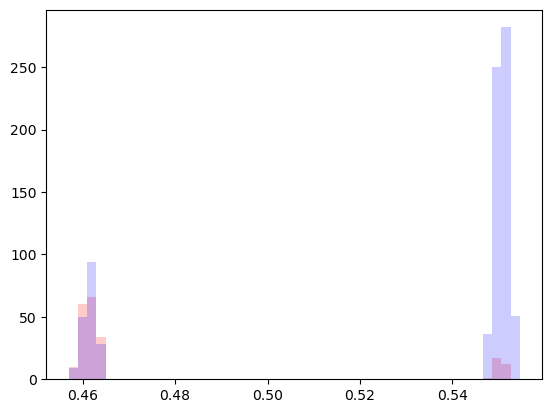

outer iteration: 999 || last perf: 0.7430 || noise auc (vi): 0.66 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 3.3e+02 s


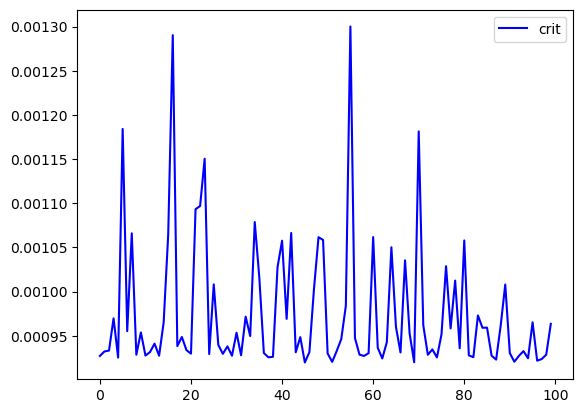

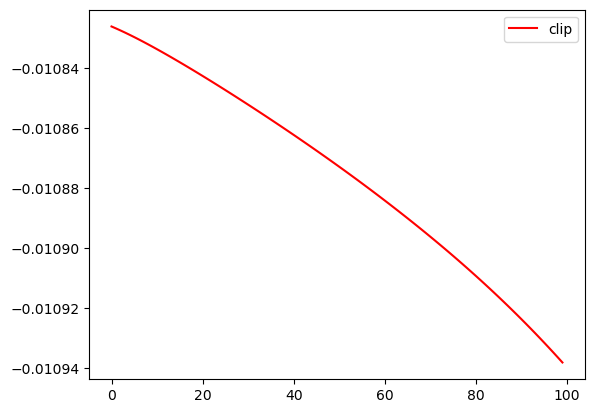

p tensor([0.5685, 0.5622, 0.4867, 0.5641, 0.4909])
v tensor([ 0.0118,  0.0060, -0.0045,  0.0061,  0.0151])


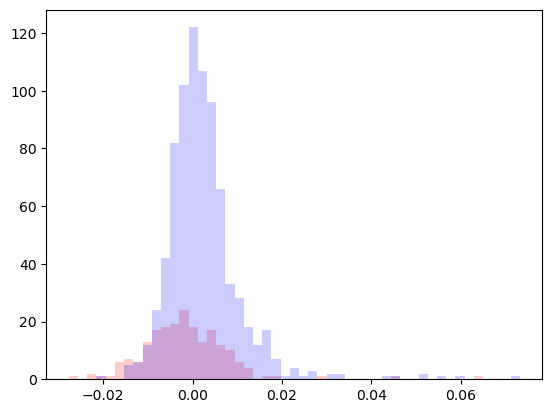

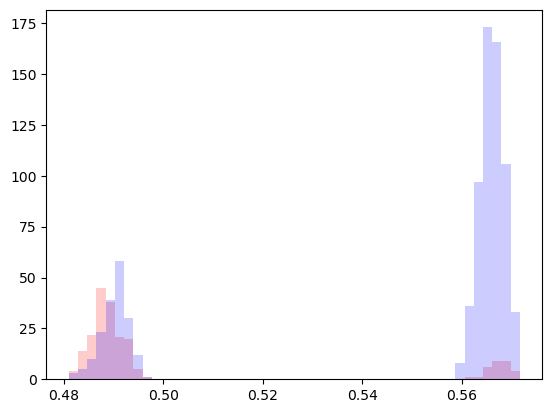

outer iteration: 999 || last perf: 0.7692 || noise auc (vi): 0.65 || noise auc (pi): 0.83|| log entropy beta: -2.00 epoch elapsed: 3.8e+02 s


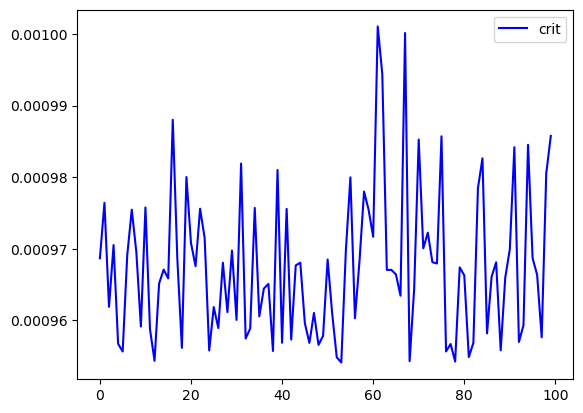

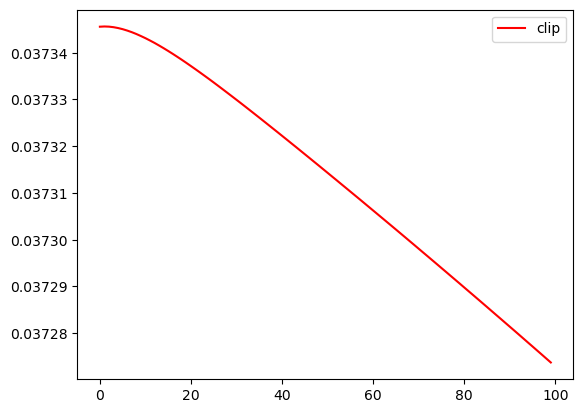

p tensor([0.5776, 0.5803, 0.4733, 0.5773, 0.5777])
v tensor([ 0.0287,  0.0045,  0.0142, -0.0045, -0.0085])


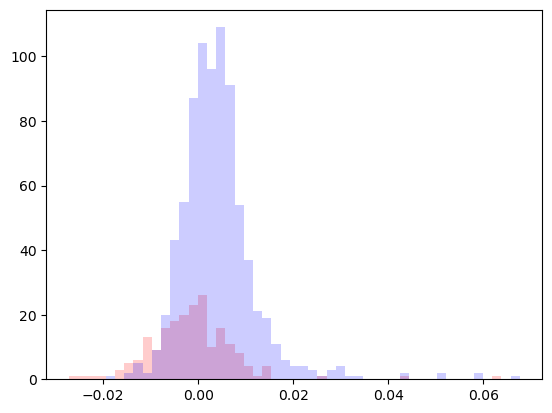

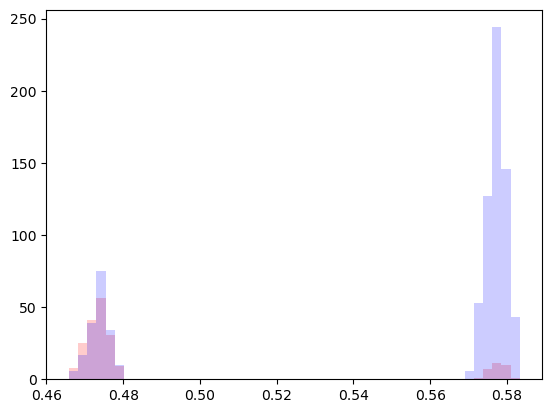

outer iteration: 999 || last perf: 0.7663 || noise auc (vi): 0.71 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 4.3e+02 s


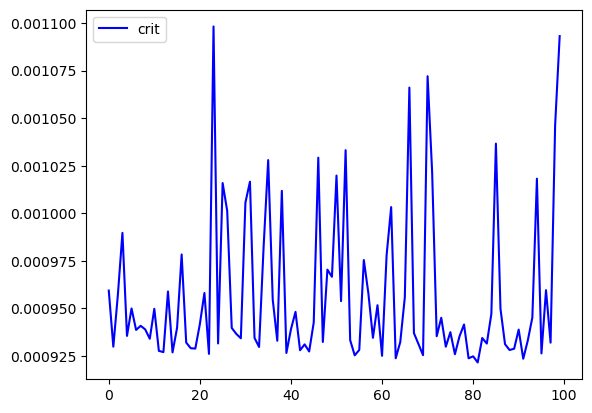

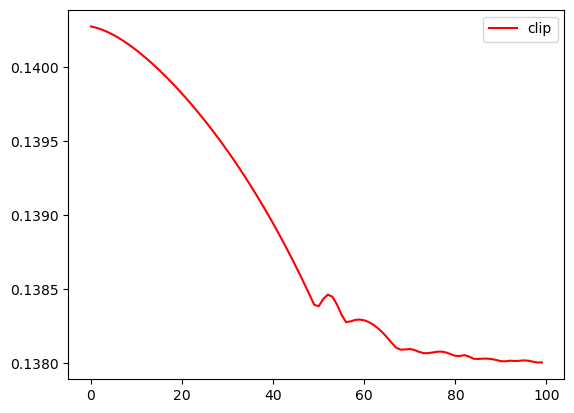

p tensor([0.6639, 0.6628, 0.6628, 0.6623, 0.6625])
v tensor([0.0167, 0.0113, 0.0013, 0.0079, 0.0050])


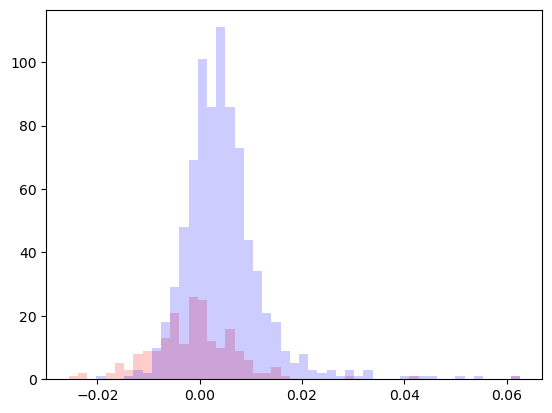

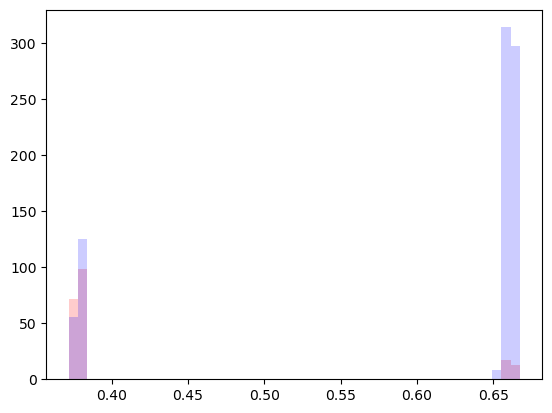

outer iteration: 999 || last perf: 0.7872 || noise auc (vi): 0.71 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 4.6e+02 s


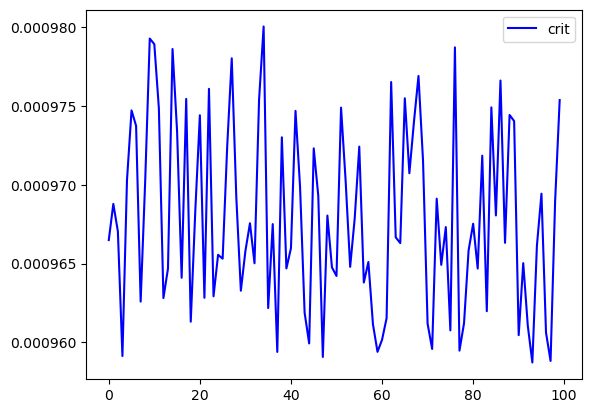

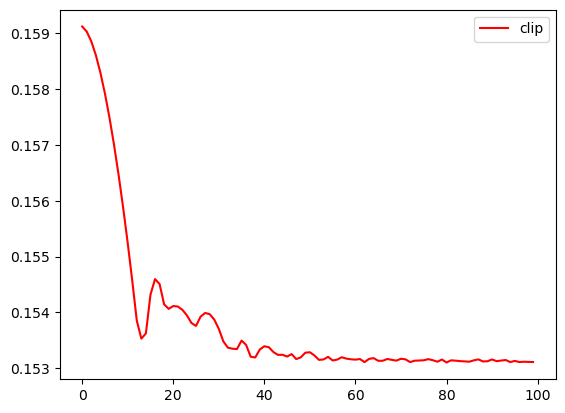

p tensor([0.3017, 0.7297, 0.3042, 0.3039, 0.7240])
v tensor([0.0136, 0.0075, 0.0039, 0.0337, 0.0016])


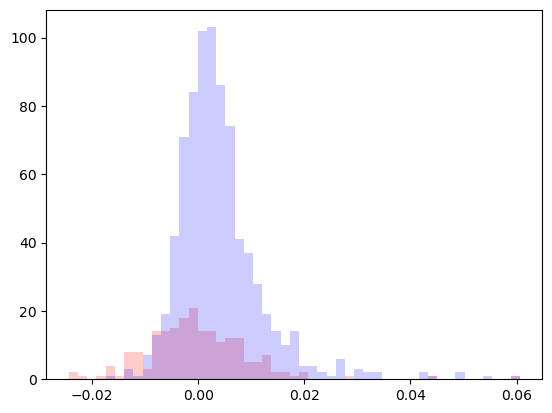

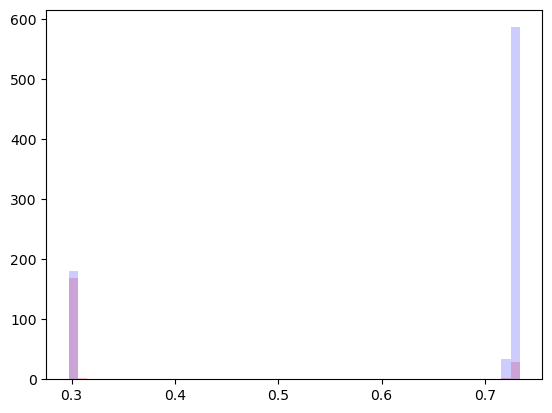

outer iteration: 999 || last perf: 0.7437 || noise auc (vi): 0.64 || noise auc (pi): 0.83|| log entropy beta: -2.00 epoch elapsed: 4.6e+02 s


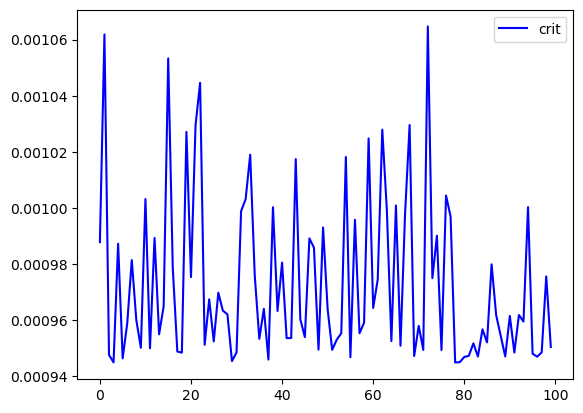

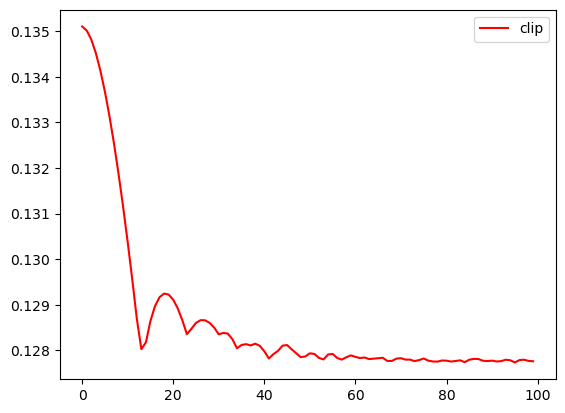

p tensor([0.2430, 0.2431, 0.7834, 0.2403, 0.7835])
v tensor([0.0313, 0.0080, 0.0033, 0.0042, 0.0005])


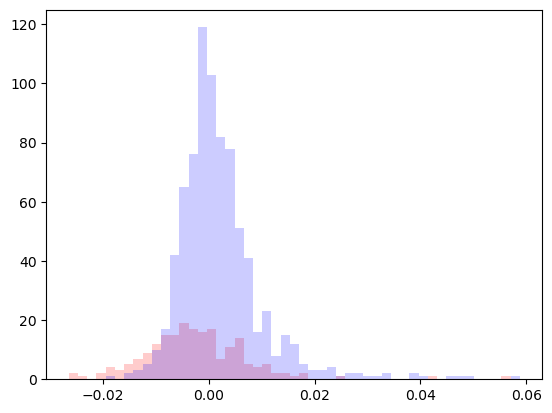

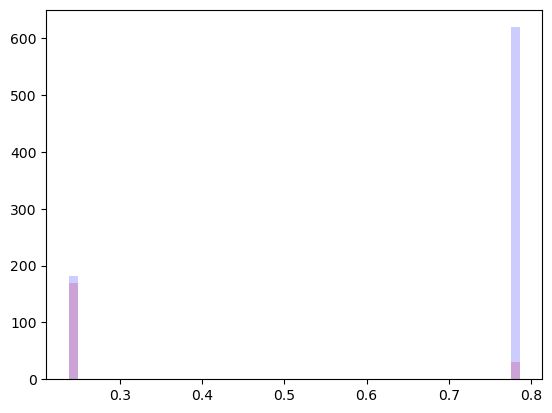

outer iteration: 999 || last perf: 0.7834 || noise auc (vi): 0.67 || noise auc (pi): 0.83|| log entropy beta: -2.00 epoch elapsed: 4.6e+02 s


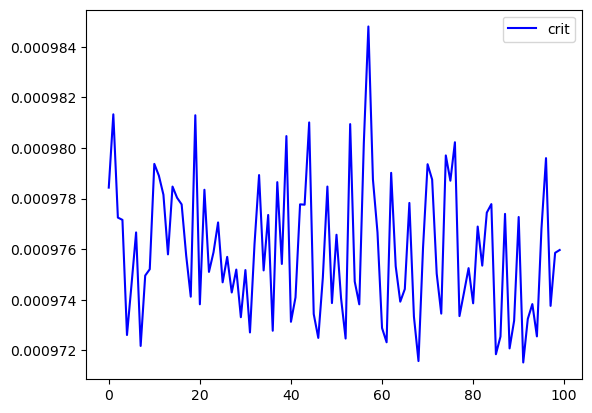

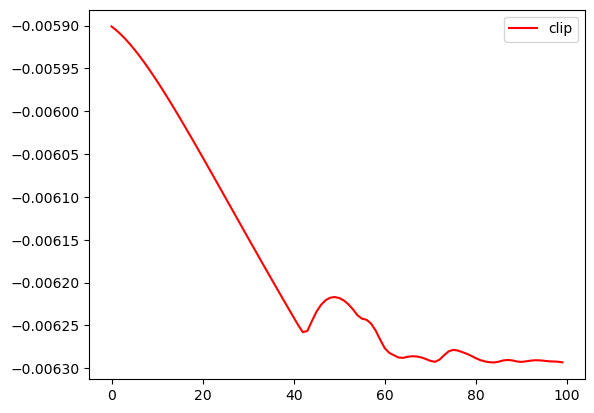

p tensor([0.7392, 0.2913, 0.2908, 0.7343, 0.7406])
v tensor([ 0.0058,  0.0084, -0.0115, -0.0077,  0.0052])


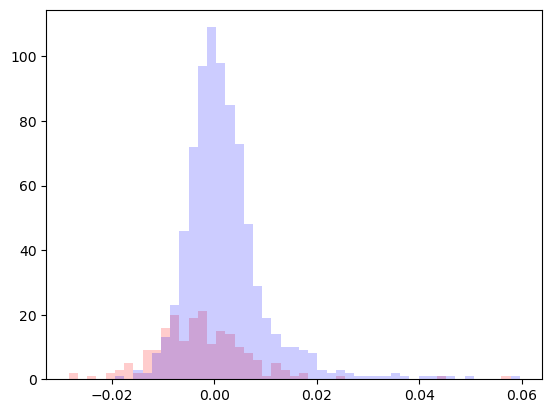

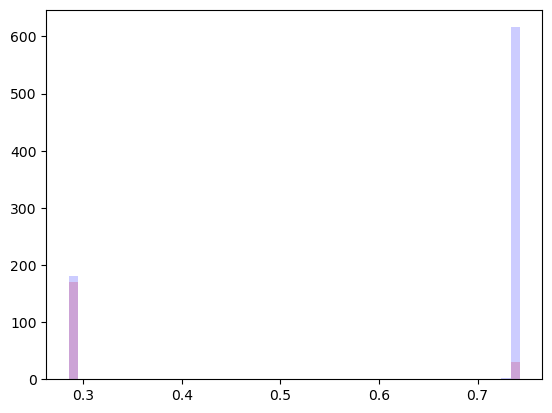

outer iteration: 999 || last perf: 0.7831 || noise auc (vi): 0.67 || noise auc (pi): 0.83|| log entropy beta: -2.00 epoch elapsed: 4.8e+02 s


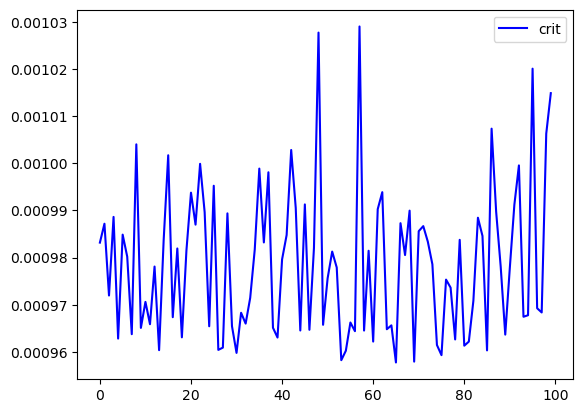

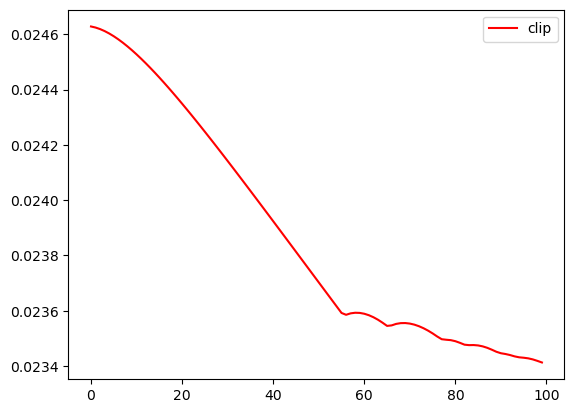

p tensor([0.7765, 0.7771, 0.7808, 0.7766, 0.7795])
v tensor([ 0.0300, -0.0050, -0.0048,  0.0004, -0.0036])


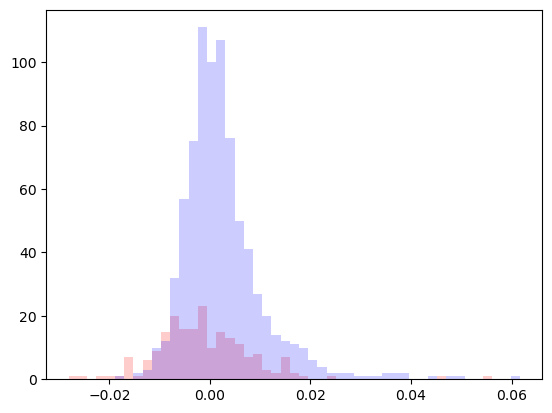

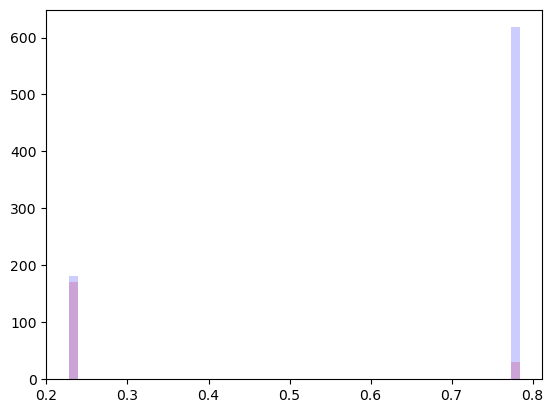

outer iteration: 999 || last perf: 0.7093 || noise auc (vi): 0.64 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 4.8e+02 s


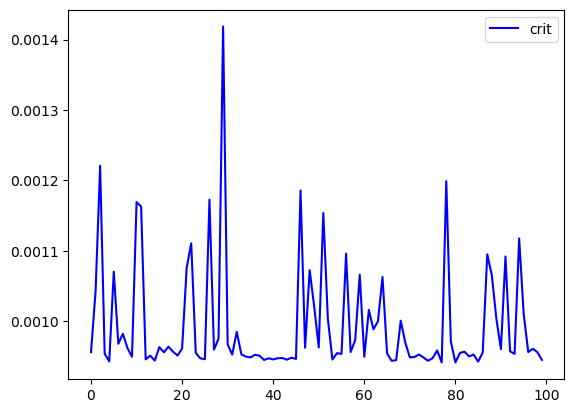

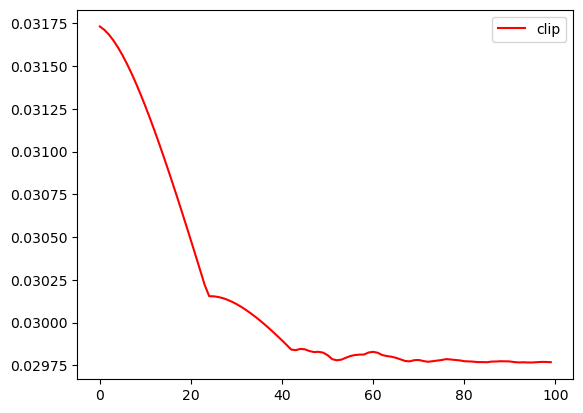

p tensor([0.8223, 0.8205, 0.8233, 0.8232, 0.8229])
v tensor([ 0.0195,  0.0030, -0.0020, -0.0049,  0.0192])


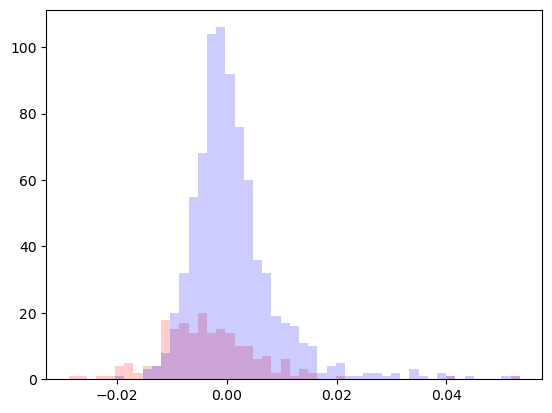

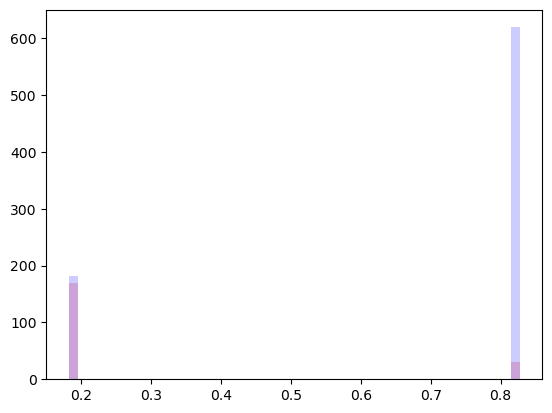

outer iteration: 999 || last perf: 0.8145 || noise auc (vi): 0.67 || noise auc (pi): 0.83|| log entropy beta: -2.00 epoch elapsed: 4.4e+02 s


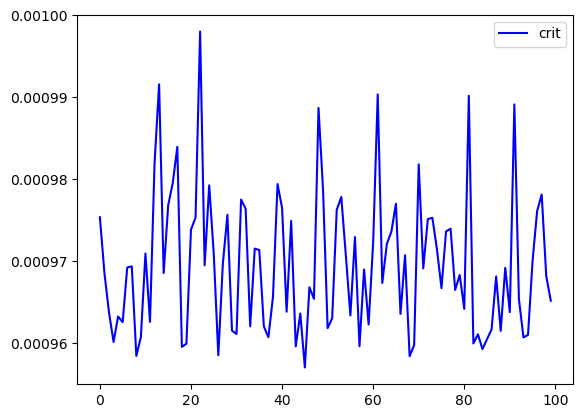

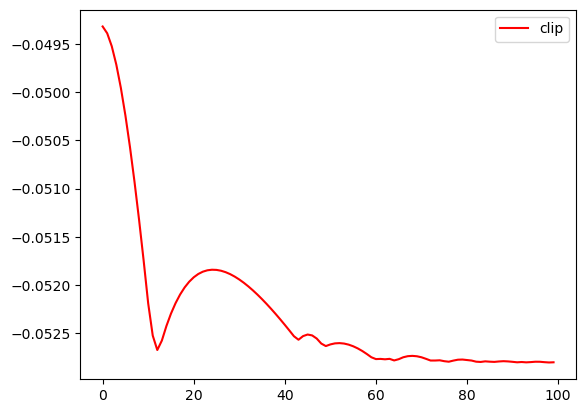

p tensor([0.7865, 0.2238, 0.7884, 0.2253, 0.2228])
v tensor([-0.0067,  0.0277, -0.0016,  0.0037,  0.0012])


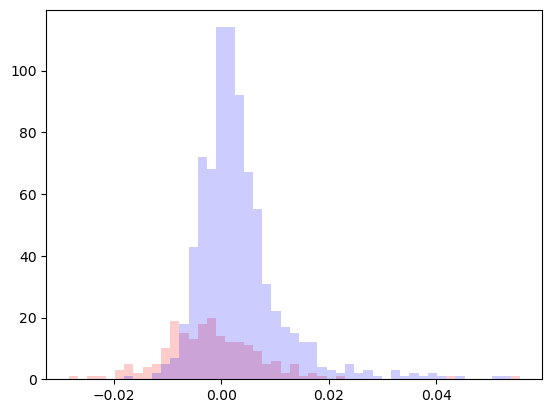

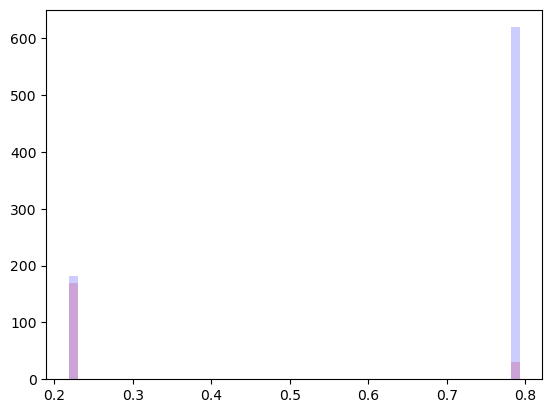

outer iteration: 999 || last perf: 0.6673 || noise auc (vi): 0.68 || noise auc (pi): 0.82|| log entropy beta: -2.00 epoch elapsed: 4.5e+02 s


KeyboardInterrupt: 

In [194]:
pred = copy.deepcopy(model) 

'''
est = Estimator(xin               = 108, 
                      yin               = 4, 
                      y_cat_dim         = 50, 
                      num_layers        = 5, 
                      hidden_channels   = 100, 
                      norm              = True, 
                      dropout           = 0., 
                      act               = torch.nn.Mish)
'''
policy = Estimator2(xin                    = 108, 
                      yin               = 2, 
                      y_cat_dim         = 50, 
                      num_layers        = 3, 
                      hidden_channels   = 100, 
                      norm              = False, 
                      dropout           = 0., 
                      act               = torch.nn.Mish,
                      out_fn            = torch.sigmoid)

critic = Estimator2(xin                    = 108, 
                      yin               = 2, 
                      y_cat_dim         = 50, 
                      num_layers        = 3, 
                      hidden_channels   = 100, 
                      norm              = False, 
                      dropout           = 0., 
                      act               = torch.nn.Mish,
                      out_fn            = torch.tanh)
#'''
dvrl = DVRL2(x_train             = x_train,
            y_train             = y_train,
            x_valid             = x_valid,
            y_valid             = y_valid,
            predictor           = pred, 
            policy              = policy,
            critic              = critic, 
            problem             = 'classification',
            include_marginal    = True)

print()

tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'auroc', 
                     crit_pred              = lambda yhat,y: torch.nn.functional.cross_entropy(yhat, y.squeeze(1)), 
                     outer_iter             = 100, 
                     inner_iter             = 50, 
                     iters_rl               = 100,
                     iters_pred             = 200,
                     outer_batch            = 1000, 
                     batch_pred             = 256, 
                     estim_lr               = 1e-4, 
                     pred_lr                = 1e-3, 
                     entropy_beta           = 1e-2,
                     entropy_decay          = 1., 
                     noise_labels           = endog_noise,
                     eps                    = 0.2,
                     use_cuda               = False,
                     rl_batch               = 10, 
                     kappa                  = 1)

vals_dvrl = vals_dvrl.detach().numpy().ravel()

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      